## Installed packages

In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import enum
import simpy
import scipy as sc
import math
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import time
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from dataclasses import dataclass
from enum import Enum
from scipy import interpolate
from scipy.signal import correlate
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model

# spatial libraries 
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate systemb
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

In [2]:
core.__file__

'c:\\users\\floorbakker\\opentnsim\\opentnsim\\core.py'

# Load data sets

In [3]:
# df_wlevel= pd.read_csv(r'C:\Users\floorbakker\OpenTNSim\notebooks\WL_dataset.csv',delimiter=',')
# df_VM= pd.read_csv(r'C:\Users\floorbakker\OpenTNSim\notebooks\VM_dataset.csv',delimiter=',')
# df_Van= pd.read_csv(r'C:\Users\floorbakker\OpenTNSim\notebooks\Van_dataset.csv',delimiter=',')

df_wlevel= pd.read_csv(r'C:\Users\floorbakker\OpenTNSim\notebooks\WL_dataset.csv',delimiter=',')
df_VM= pd.read_csv(r'C:\Users\floorbakker\OpenTNSim\notebooks\VM_dataset.csv',delimiter=',')
df_Van= pd.read_csv(r'C:\Users\floorbakker\OpenTNSim\notebooks\Van_dataset.csv',delimiter=',')

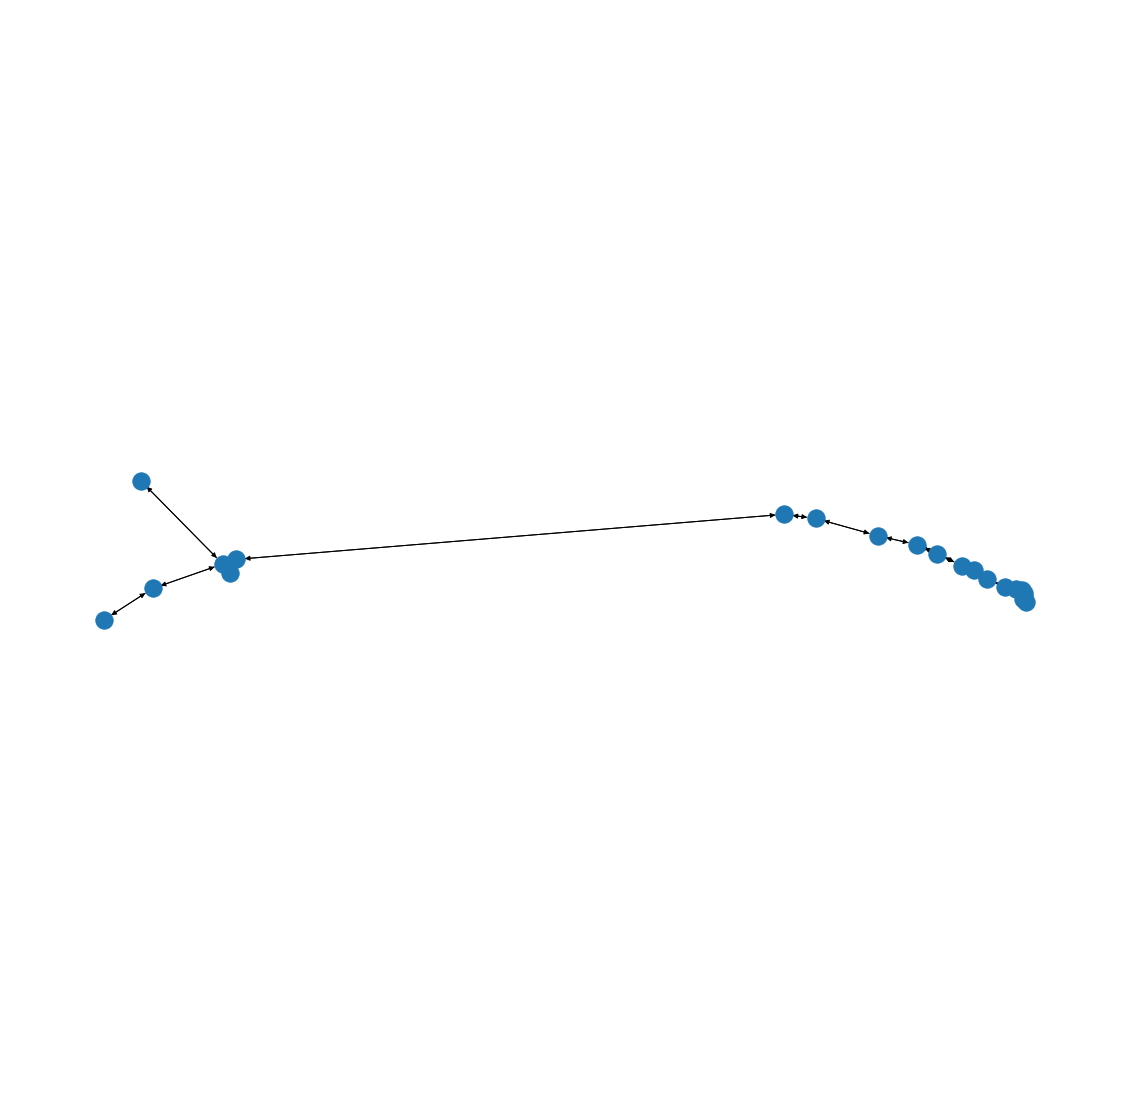

In [4]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
coords = []

coords.append([2.68276,51.84278]) #node_1 origin
coords.append([2.76847,51.8981])#node_2
coords.append([2.89251,51.94136])#node_3
coords.append([2.91627,51.94957])#node_4
coords.append([3.88419,52.02922])#node_5
coords.append([3.93995795592471,52.0219158335973]) #node_6
coords.append([4.04961843717028,51.9913123648208]) #node_7
coords.append([4.1187846584378,51.9756279862634]) #node_8
coords.append([4.15471631295706,51.9596283586068]) #node_9
coords.append([4.19884102088863,51.9382313719035]) #node_10
coords.append([4.22030870030092,51.9302898518613]) #node_11
coords.append([4.24286991304305,51.9141858383526]) #node_12
coords.append([4.27537465881064,51.9015756264453]) #node_13
coords.append([4.29337962495028,51.8968867771695]) #node_14
coords.append([4.30388786112617,51.8947760348761]) #node_15
coords.append([4.308557,51.889522]) #node_16 turning basin
coords.append([4.308335,51.884692])#node_17 
coords.append([4.306804,51.879432]) #node_18
coords.append([4.312392,51.874262]) #node_19, destination
coords.append([2.9054,51.92534]) #node_20, anchorage 1 north
coords.append([2.7474,52.08876]) #node_21, anchorage 2 south

for d in range(len(coords)):
    data_node = {"env": [],
                 "name": "Node " + str(d+1),
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)
    
for i in range(len(nodes)-3):
    path.append([nodes[i],nodes[i+1]]) 
    path.append([nodes[i+1],nodes[i]])
    
path.append([nodes[2],nodes[19]]) # channel - anchorage 1 
path.append([nodes[19],nodes[2]]) # anchorage 1- channel
path.append([nodes[2],nodes[20]])  # channel - anchorage 2
path.append([nodes[20],nodes[2]])  # anchorage 2-channel


FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {})

fig, ax = plt.subplots(figsize=(20, 20))
nx.draw(FG, positions)
plt.axis('equal')
plt.show()

In [5]:
# Plot the network 
m = folium.Map(location=[52, 3.4], zoom_start = 9, tiles="cartodbpositron")

line = []
for node in list(FG.nodes())[0:19]:
    points_x = FG.nodes[node]["geometry"].x
    points_y = FG.nodes[node]["geometry"].y
    line.append([points_y, points_x])
    if node == 'Node 3':
        line.append([FG.nodes['Node 20']["geometry"].y, FG.nodes['Node 20']["geometry"].x])
        line.append([points_y, points_x])
        line.append([FG.nodes['Node 21']["geometry"].y, FG.nodes['Node 21']["geometry"].x])
        line.append([points_y, points_x])
    
folium.PolyLine(line, weight = 2).add_to(m)

m

In [6]:
simulation_start = datetime.datetime.now()
sim = model.Simulation(simulation_start,FG)
env = sim.environment
duration = 14*24*3600 #seconds
#duration = 15290000 #seconds


In [7]:
terminal_1 = core.IsTerminal(env = env, 
                             name = 'Koole terminal',
                             length = 700, 
                             node_start = 'Node 18', 
                             node_end = 'Node 19', 
                             type = 'quay')

The Koole terminal has 5 deepsea jetties, coaster+IWT jetties, and 6 jetties dedicated for IWT. For this exercise I'll only take the 5 deepsea jetties and I'll add them to a single terminal

In [8]:
env.FG = FG

turning_basin_1 = core.IsTurningBasin(env = env, name = 'Turning Basin 1', node = 'Node 16', length = 300)

origin_1 = core.IsOrigin(env = env, name = 'Origin 1')

anchorage_1 = core.IsAnchorage(env = env, name = 'Anchorage 1', node = 'Node 20', type = 'sea_going_vessels',max_capacity = 50)
anchorage_2 = core.IsAnchorage(env = env, name = 'Anchorage 2', node = 'Node 21', type = 'sea_going_vessels',max_capacity = 50)

terminal_1 = core.IsTerminal(env = env, name = 'Koole terminal',length = 700, jetty_locations = [100,200,300,400,500], jetty_lengths = [300,300,300,300,300], node_start = 'Node 18', node_end = 'Node 19', type = 'quay')

## Anchorage capacity

Argument: Anchorage areas 3A + 3C seems to have around 10 ships at the same time (Marine Traffic.com and master thesis by Devillé). 

what is a reasonable value of the anchorage capacity?

In [9]:
FG.nodes["Node 1"]["Origin"] = [origin_1]

FG.nodes["Node 20"]["Anchorage"] = [anchorage_1]

FG.nodes["Node 21"]["Anchorage"] = [anchorage_2]

FG.nodes["Node 16"]["Turning Basin"] = [turning_basin_1]

# FG.nodes["Node 18"]["Turning Basin"] = [turning_basin_2] I could add this one later on

FG.nodes["Node 1"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #origin
FG.nodes["Node 1"]["Junction"].name = ['waterway_access']
FG.nodes["Node 1"]["Junction"].type = ['two-way_traffic']

FG.nodes["Node 16"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #turn Basin acccess to 3e PH
FG.nodes["Node 16"]["Junction"].name = ['waterway_access','harbour_basin_access']
FG.nodes["Node 16"]["Junction"].type = ['two-way_traffic','one-way_traffic']

#FG.nodes["Node 17"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #start terminal
#FG.nodes["Node 17"]["Junction"].name = ['waterway_access','waterway_access']
#FG.nodes["Node 17"]["Junction"].type = ['one-way_traffic','one-way_traffic']

#FG.nodes["Node 18"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #middle part of the terminal
#FG.nodes["Node 18"]["Junction"].name = ['waterway_access','harbour_basin_access']
#FG.nodes["Node 18"]["Junction"].type = ['one-way_traffic','one-way_traffic']

FG.nodes["Node 19"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #end point route
FG.nodes["Node 19"]["Junction"].name = ['harbour_basin_access']
FG.nodes["Node 19"]["Junction"].type = ['one-way_traffic']

FG.nodes["Node 3"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #neural point
FG.nodes["Node 3"]["Junction"].name = ['waterway_access','waterway_access','anchorage_access','anchorage_access']
FG.nodes["Node 3"]["Junction"].type = ['two-way_traffic','two-way_traffic','two-way_traffic','two-way_traffic']

FG.nodes["Node 20"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #anchorage 1
FG.nodes["Node 20"]["Junction"].name = ['anchorage_access']
FG.nodes["Node 20"]["Junction"].type = ['two-way_traffic']

FG.nodes["Node 21"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #anchorage 2
FG.nodes["Node 21"]["Junction"].name = ['anchorage_access']
FG.nodes["Node 21"]["Junction"].type = ['two-way_traffic']


junction_nodes = []
for node in list(FG.nodes):
    if 'Junction' in FG.nodes[node]:
        junction_nodes.append(node)
        
for node1 in junction_nodes:
    names = []
    sections = []
    types = []
    for node2 in junction_nodes:
        if node1 == node2:
            continue
            
        route = nx.dijkstra_path(FG, node1, node2)
        section = True
        for node in route[1:-1]:
            if 'Junction' in FG.nodes[node]:
                section = False
                break

        if section:
            sections.append([node1,node2])
            names.append(FG.nodes[node1]["Junction"].name[len(sections)-1])
            types.append(FG.nodes[node1]["Junction"].type[len(sections)-1])
    
    FG.nodes[node1]["Junction"] = [core.IsJunction(env = env, name = names, sections = sections, type = types)]
            
FG.edges['Node 18','Node 19']["Terminal"] = [terminal_1]

for edge in enumerate(FG.edges):
    if 'Terminal' in FG.edges[edge[1]]:
        FG.edges[edge[1][1],edge[1][0]]['Terminal'] = FG.edges[edge[1]]['Terminal']

In [10]:
# List 8 vessels
vdf = pd.DataFrame()
vdf[0] = ['Small coaster 1','Small coaster 2','Coaster','Handysize','Tanker MR','Tanker LR1','Tanker LR2 1','Tanker LR2 2']
vdf[1] = [71,110,126,149,184,228,243,249] #length
vdf[2] = [10.1,13.5,19,22,27,32,42,46] #beam
vdf[3] = [4.5,5.45,8.5,10,11.4,12.1,13.6,15] # draught + FWA
vdf[4] = 0.5*vdf[3] #unloaded draught
vdf[5] = [17,17,17,17,17,17,17,17] #H_e free board empty- Update!
vdf[6] = vdf[5]-(vdf[3]-vdf[4]) #H_f free board loaded
vdf[7] = [60,60,60,60,60,60,60,60] #t_b in minutes - berthing time (assumed in 1hs)
vdf[8] = [15*60,16.7*60,16.7*60,18.3*60,18.3*60,18.3*60,18.3*60,18.3*60] #t_l loading + unloading time (in minutes)
vdf[9] = [0,0,0,0,0,0,0,0] #UKC
vdf[10] = [4.5,4.5,4.5,4.5,4.5,4.5,4.5,4.5] # vessel speed in m/s - check with S. de Jong thesis
# vdf[10] = [6,6,6,6,6,6,6,6] # vessel speed in m/s - own assumption
vdf[11] = [18*60*60,18*60*60,18*60*60,18*60*60,18*60*60,18*60*60,18*60*60,18*60*60] # max waiting time in seconds
vdf[12] = [0,0,0,0,0,0,0,0] #critical cross-current velocity in m/s
vdf.columns = ['type','L','B','T_f','T_e','H_e','H_f','t_b','t_l','ukc','v','max_waiting_time','max_cross_current']
vdf

,type,L,B,T_f,T_e,H_e,H_f,t_b,t_l,ukc,v,max_waiting_time,max_cross_current
0,Small coaster 1,71,10.1,4.50,2.250,17,14.750,60,900.0,0,4.5,64800,0
1,Small coaster 2,110,13.5,5.45,2.725,17,14.275,60,1002.0,0,4.5,64800,0
2,Coaster,126,19.0,8.50,4.250,17,12.750,60,1002.0,0,4.5,64800,0
3,Handysize,149,22.0,10.00,5.000,17,12.000,60,1098.0,0,4.5,64800,0
4,Tanker MR,184,27.0,11.40,5.700,17,11.300,60,1098.0,0,4.5,64800,0
5,Tanker LR1,228,32.0,12.10,6.050,17,10.950,60,1098.0,0,4.5,64800,0
6,Tanker LR2 1,243,42.0,13.60,6.800,17,10.200,60,1098.0,0,4.5,64800,0
7,Tanker LR2 2,249,46.0,15.00,7.500,17,9.500,60,1098.0,0,4.5,64800,0


Explanation parameters: 
- max current: for Node 15 a maximum FLOOD current of 0.5knots is defined --> I'll assume the same limit as CROSS-CURRENT for that node
- For nodes between 15 and 19 (to destination), the same limit is applied.
- max current: for the rest of the nodes, define a theoretical value for the open sea and another for the NWW channel --> values in PIANC Design of Harbour Approach channels --> open sea: strong current 2knots ; channel=moderate current 1.5knots


Max waiting time:
For liquid bulk = 18hs so it is the same as the largest value of the service time --> check with literature!

Terminal occupancy, typical value for a liquid bulk terminal (van Koninsgveld et al, 2021)
the acceptable berth occupancy lies between 40% for a single berth and 80% for four berths --> in this case, 4/5 jetties are occupied

Service time --> values based on EIA deepening project

Arrival time --> define value in such a way that there is a terminal occupancy of 0.6-0.8 and no port congestion.
ASK FLOOR IF THE MODEL CAN USE STOCHASTIC ARRIVAL TIME DISTRIBUTIONS

Duration of the sumlation and number of generated vessels --> number of generated vessels defines the accuracy of the generator (sampling uniform distribution) 


In [11]:
## USE THIS CELL FOR SHIP GENERATOR WITH constant ARRIVAL RATE
Vessel = type('Vessel', 
              (core.Identifiable, core.Movable, core.Routeable, core.VesselProperties, core.ExtraMetadata), {})

generator_sea = model.VesselGenerator(Vessel,vdf,random_seed=3)

In [12]:
### USE THIS CELL FOR SHIP GENERATOR WITH constant ARRIVAL RATE
origin = 'Node 1' #coasters should enter empty and leave full (export) --> UPDATE SOMEWHERE
destination = 'Node 19'
sim.add_vessels(vessel_generator = generator_sea, origin = origin, destination = destination, 
                arrival_distribution = (3600/(5.5*3600)), arrival_process = 'Uniform', fleet_distribution = [1,1,1,1,1,1,1,1])


## WATER LEVEL AND VELOCITY FIELD + BATHYMETRY (water depth)

In [13]:
#define variables
depth = [[],[]]
width = [[],[]]
MBL = [[],[]]
water_level=[[],[]]
current_velocity = [[],[]]
current_direction = [[],[]]
time = np.arange(0,duration,60)

# depth according to MBL values, and waterway navigational width obtained from measuring on HavenKaart
MBL[1] = [50,50,50,50,50,24.3,16.2,16.2,16.4,16.4,16.4,16.4,16.4,16.4,16.4,16.4,16.4,16.4,50,50,50]
depth[1] = MBL[1]
width[1] = [1000,1000,1000,1000,1000,600,300,300,200,200,200,200,200,200,200,200,180,180,180,1000,1000]

# load water level, velocity magnitude and direction time series to each node
for nodes in enumerate(FG.nodes):
    MBL[0].append(FG.nodes[nodes[1]]['geometry'])
    width[0].append(FG.nodes[nodes[1]]['geometry'])
    depth[0].append((FG.nodes[nodes[1]]['geometry']))
    water_level[0].append((FG.nodes[nodes[1]]['geometry']))
    water_level[1].append([[],[]])
    current_velocity[0].append((FG.nodes[nodes[1]]['geometry']))
    current_velocity[1].append([[],[]])
    current_direction[0].append((FG.nodes[nodes[1]]['geometry']))
    current_direction[1].append([[],[]])
    
for col in enumerate(df_wlevel.columns[1:]): #load water level
    water_level[1][col[0]][0]=[x-df_wlevel[df_wlevel.columns[0]][0]+simulation_start.timestamp() for x in list(df_wlevel[df_wlevel.columns[0]])]
    water_level[1][col[0]][1]=list(df_wlevel[col[1]])    
    
for col in enumerate(df_VM.columns[1:]): #load velocity magnitude
    current_velocity[1][col[0]][0]=[x-df_VM[df_VM.columns[0]][0]+simulation_start.timestamp() for x in list(df_VM[df_VM.columns[0]])]
    current_velocity[1][col[0]][1]=list(df_VM[col[1]])
     
for col in enumerate(df_Van.columns[1:]): #load velocity direction
    current_direction[1][col[0]][0]=[x-df_Van[df_Van.columns[0]][0]+simulation_start.timestamp() for x in list(df_Van[df_Van.columns[0]])]
    current_direction[1][col[0]][1]=list(df_Van[col[1]])

core.NetworkProperties.append_data_to_nodes(FG,width,depth,MBL,water_level,current_velocity,current_direction)
knots = 0.51444444444444

In [14]:
class window_method(Enum):
    critical_cross_current = 'Critical cross-current'
    point_based = 'Point-based'
    
class vessel_characteristics(Enum):
    min_ge_Length = ['minLength','>=']
    min_gt_Length = ['minLength','>']
    max_le_Length = ['maxLength','<=']
    max_lt_Length = ['maxLength','<']
    min_ge_Draught = ['minDraught','>=']
    min_gt_Draught = ['minDraught','>']
    max_le_Draught = ['maxDraught','<=']
    max_lt_Draught = ['maxDraught','<']
    min_ge_Beam = ['minBeam','>=']
    min_gt_Beam = ['minBeam','>']
    max_le_Beam = ['maxBeam','<=']
    max_lt_Beam = ['maxBeam','<']
    min_ge_UKC = ['minUKC','>=']
    min_gt_UKC = ['minUKC','>']
    max_le_UKC = ['maxUKC','<=']
    max_lt_UKC = ['maxUKC','<']
    Type = ['Type','==']

class vessel_direction(Enum):
    inbound = 'inbound'
    outbound = 'outbound'
    
class vessel_type(Enum):
    GeneralCargo = 'GeneralCargo'
    LiquidBulk = 'LiquidBulk'
    Container = 'Container'
    DryBulk = 'DryBulk'
    MultiPurpose = 'MultiPurpose'
    Reefer = 'Reefer'
    RoRo = 'RoRo'
    Barge = 'Barge'
    
class accessibility(Enum):
    non_accessible = 0
    accessible = -1
    
class tidal_period(Enum):
    Flood = 'Flood'
    Ebb = 'Ebb'
    
class current_velocity_type(Enum):
    CurrentVelocity = 'Current velocity'
    LongitudinalCurrent = 'Longitudinal current'
    CrossCurrent = 'Cross-current'
    
@dataclass
class vessel_specifications:
    vessel_characteristics: dict #{item of vessel_characteristics class: user-defined value,...}
    vessel_method: str #string containing the operators between the vessel characteristics (symbolized by x): e.g. '(x and x) or x'
    vessel_direction: str #item of vessel_direction class

    def characteristic_dicts(self):
        characteristic_dicts = {}
        for characteristic in self.vessel_characteristics:
            characteristic_dict = {characteristic.value[0]: [characteristic.value[1],self.vessel_characteristics[characteristic]]}
            characteristic_dicts = characteristic_dicts | characteristic_dict
        return characteristic_dicts

@dataclass
class window_specifications:
    window_method: str #item of window_method class
    current_velocity_values: dict #{tidal_period.Flood.value: user-defined value or item from accessibility class,...}
    current_velocity_ranges: dict = dict #if window_method is point-based: {tidal_period.Ebb.value: user-defined value,...}

@dataclass
class vtw_window_specifications:
    ukc_s: dict #{tidal_period.Flood.value: user-defined value or item from accessibility class,...}
    ukc_p: dict #{tidal_period.Flood.value: user-defined value or item from accessibility class,...}
    fwa: dict #{tidal_period.Flood.value: user-defined value or item from accessibility class,...}

@dataclass
class vertical_tidal_window_input:
    vessel_specifications: vessel_specifications #class
    window_specifications: window_specifications #class     
        
@dataclass
class horizontal_tidal_window_input:
    vessel_specifications: vessel_specifications #class
    window_specifications: window_specifications #class     
    condition: dict #{'Origin':node, 'Destination': node}
    data: list #Calculated input: [node,]

In [15]:
for node in FG.nodes:
    vertical_tidal_window_inputs = []

    vessel_specification = vessel_specifications({vessel_characteristics.min_ge_Draught: 0},
                                                  'x',vessel_direction.inbound.value)

    window_specification = vtw_window_specifications({'ukc_s': 0.0},
                                                     {'ukc_p': 0.1},
                                                     {'fwa': 0.025})
    
    vertical_tidal_window_inputs.append(vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                    window_specifications = window_specification))

    vessel_specification = vessel_specifications({vessel_characteristics.min_ge_Draught: 0},
                                                  'x',vessel_direction.outbound.value)

    window_specification = vtw_window_specifications({'ukc_s': 0.0},
                                                     {'ukc_p': 0.1},
                                                     {'fwa': 0.025})

    vertical_tidal_window_inputs.append(vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                    window_specifications = window_specification))

    core.NetworkProperties.append_vertical_tidal_restriction_to_network(FG,node,vertical_tidal_window_inputs)

In [16]:
horizontal_tidal_window_inputs = []

#Inbound_Vessels_Condition1
vessel_specification = vessel_specifications({vessel_characteristics.min_ge_Length: 180,
                                              vessel_characteristics.min_ge_Draught: 11.4,
                                              vessel_characteristics.max_lt_Draught: 14.3},
                                              '(x and x and x)',vessel_direction.inbound.value)

window_specification = window_specifications(window_method.critical_cross_current.value,
                                             {tidal_period.Flood.value: 2*knots,tidal_period.Ebb.value: 2*knots})

horizontal_tidal_window_inputs.append(horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                    window_specifications = window_specification,
                                                                    condition = {'Origin': 'Node 14', 'Destination': 'Node 17'},
                                                                    data = ['Node 14', current_velocity_type.CurrentVelocity.value]));

#Inbound_Vessels_Condition2
vessel_specification = vessel_specifications({vessel_characteristics.min_ge_Draught: 14.3},
                                              'x',vessel_direction.inbound.value)

window_specification = window_specifications(window_method.point_based.value,
                                             {tidal_period.Flood.value: 0.5*knots,tidal_period.Ebb.value: accessibility.accessible.value},
                                             {tidal_period.Flood.value: 0.3,tidal_period.Ebb.value:0})

horizontal_tidal_window_inputs.append(horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                    window_specifications = window_specification,
                                                                    condition = {'Origin': 'Node 14', 'Destination': 'Node 17'},
                                                                    data = ['Node 14', current_velocity_type.CurrentVelocity.value]));

#Outbound_Vessels_Condition1
vessel_specification = vessel_specifications({vessel_characteristics.max_lt_Draught: 14.3},
                                              'x',vessel_direction.outbound.value)

window_specification = window_specifications(window_method.point_based.value,
                                             {tidal_period.Flood.value: 2*knots,tidal_period.Ebb.value: accessibility.accessible.value},
                                             {tidal_period.Flood.value: 0,tidal_period.Ebb.value:0})

horizontal_tidal_window_inputs.append(horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                    window_specifications = window_specification,
                                                                    condition = {'Origin': 'Node 17', 'Destination': 'Node 14'},
                                                                    data = ['Node 14', current_velocity_type.CurrentVelocity.value]));

#Outbound_Vessels_Condition2
vessel_specification = vessel_specifications({vessel_characteristics.min_ge_Draught: 14.3},
                                              'x',vessel_direction.outbound.value)

window_specification = window_specifications(window_method.point_based.value,
                                             {tidal_period.Flood.value: 0.5*knots,tidal_period.Ebb.value: accessibility.non_accessible.value},
                                             {tidal_period.Flood.value: 0.3,tidal_period.Ebb.value:0})

horizontal_tidal_window_inputs.append(horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                    window_specifications = window_specification,
                                                                    condition = {'Origin': 'Node 17', 'Destination': 'Node 14'},
                                                                    data = ['Node 14', current_velocity_type.CurrentVelocity.value]));

core.NetworkProperties.append_horizontal_tidal_restriction_to_network(FG,'Node 15',horizontal_tidal_window_inputs)

Choice about the bathymetry

make all 16.4m until destination point, even if it is the MBL shown in the Haven Kaart
Realistic MBL would be 16.4 at Node 15
Then, 15.9 from Node 16 to 19 --> inside the basins

Since the UKC policy is different in the NWW than inside the basins, it results in that the required water depth inside the basin is lower than in the NWW. UKC=0.5m for any vessel inside the basisn VS UKC=10%D for the NWW

In [17]:
#water_level[1][col[0]][1][0]

In [18]:
#print(df_wlevel[df_wlevel.columns[0]])
#print(df_wlevel[df_wlevel.columns[0]][:])
#print(water_level[1][col[0]][0])

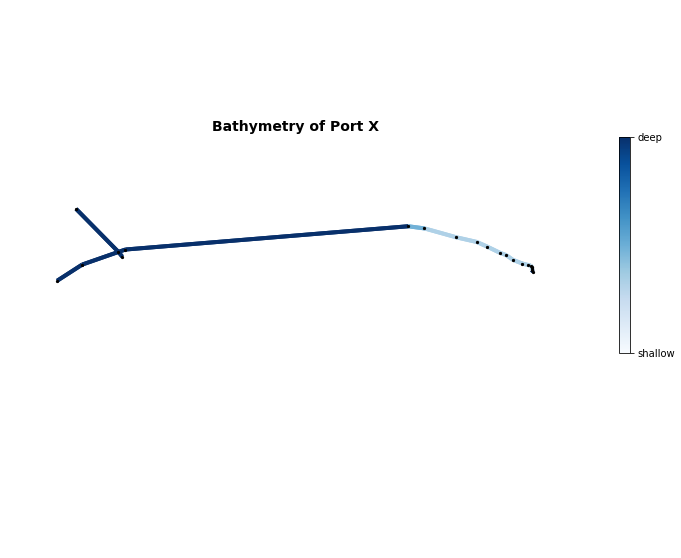

In [19]:
edge_count = []
for edge in enumerate(FG.edges):
    edge_count.append(FG.edges[edge[1]]['Info']['Depth'][0])

colormap = cm.get_cmap('Blues', 256)
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
ax = fig.add_axes([0, 0.4, 1, 0.3]);
nx.draw(FG, positions, node_size = 5, node_color ='k', with_labels = False, horizontalalignment = 'right', verticalalignment = 'bottom', edge_color = edge_count, edge_cmap = colormap, edge_vmin = 0, arrows = False, width= 4)
plt.axis('equal')
cbar = fig.colorbar(cm.ScalarMappable(cmap=colormap), ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['shallow','deep'])  # vertically oriented colorbar
plt.title('Bathymetry of Port X',fontsize = 14, fontweight='bold')
plt.show()

In [20]:
core.Output.general_output(sim)
core.Output.node_dependent_output(env.FG)
core.Output.edge_dependent_output(env.FG)

In [21]:
t0 = timepy.time()
sim.run(duration = duration) # this statement runs the simulation
t1 = timepy.time()
total = t1-t0
print(total) #simulation time in seconds

222.97882843017578


In [22]:
def readjust_available_quay_lengths(aql,position):
    for i in range(len(aql)):
        if i == 0:
            continue
        if aql[i - 1][1] < position and aql[i][1] > position:
            break

    if i == 1:
        aql[i - 1][0] = 0
        aql[i][0] = 0

    elif i == len(aql) - 1:
        aql[i - 1][0] = 0
        aql[i][0] = 0

    else:
        aql[i - 1][0] = 0
        aql[i][0] = 0

    to_remove = []
    for i in enumerate(aql):
        for j in enumerate(aql):
            if i[0] != j[0] and i[1][0] == 0 and j[1][0] == 0 and i[1][1] == j[1][1]:
                to_remove.append(i[0])

    for i in list(reversed(to_remove)):
        aql.pop(i)

    return aql

def pick_minimum_length(aql,L):
    available_quay_lengths = [0]
    index_quay_position = 0
    move_to_anchorage = False
    for index in range(len(aql)):
        if index == 0 or aql[index][1] == aql[index - 1][1] or aql[index][0] == 1:
            if index == len(aql) - 1 and not index_quay_position:
                move_to_anchorage = True
            continue

        available_quay_lengths.append(aql[index][1] - aql[index - 1][1])

        for jndex in range(len(available_quay_lengths)):
            if L <= available_quay_lengths[jndex]:
                index_quay_position = index
                print(index_quay_position)
                break

            elif jndex == len(available_quay_lengths) - 1 and not index_quay_position:
                move_to_anchorage = True
        
        if index_quay_position != 0:
            break

    return index_quay_position, move_to_anchorage

def adjust_available_quay_lengths(aql, L, index_quay_position):
    if aql[index_quay_position - 1][0] == 0:
        aql[index_quay_position - 1][0] = 1

    if aql[index_quay_position][0] == 0 and aql[index_quay_position][1] == aql[index_quay_position - 1][1] + L:
        aql[index_quay_position][0] = 1
    else:
        aql.insert(index_quay_position, [1, L + aql[index_quay_position - 1][1]])
        aql.insert(index_quay_position + 1, [0, L + aql[index_quay_position - 1][1]])
        
    print(0.5 * L + aql[index_quay_position - 1][1])
    return aql

In [23]:
vessels = sim.environment.vessels #extract vessels (entitie) from environment. It collects info while it moves through the network. That info is stored in the log file. The log file has 
env = sim.environment #extract the environment itself

In [24]:
# pd.set_option('display.max_rows', 500)
vessel = vessels[2]
print(vessel.type)
df = pd.DataFrame.from_dict(vessel.log) #creates a data frame with all the info of vessels[0].
df

Coaster


,Message,Timestamp,Value,Geometry
0,Sailing from node Node 1 to node Node 2 start,2022-01-27 07:58:55.000000,40.778655,POINT (2.68276 51.84278)
1,Sailing from node Node 1 to node Node 2 stop,2022-01-27 08:30:30.230296,40.598531,POINT (2.76847 51.8981)
2,Sailing from node Node 2 to node Node 3 start,2022-01-27 08:30:30.230296,40.598531,POINT (2.76847 51.8981)
3,Sailing from node Node 2 to node Node 3 stop,2022-01-27 09:06:47.536288,40.370277,POINT (2.89251 51.94136)
4,Sailing from node Node 3 to node Node 4 start,2022-01-27 09:06:47.536288,40.370277,POINT (2.89251 51.94136)
...,...,...,...,...
80,Sailing from node Node 3 to node Node 2 stop,2022-01-28 17:25:34.988295,40.300622,POINT (2.76847 51.8981)
81,Sailing from node Node 2 to node Node 1 start,2022-01-28 17:25:34.988295,40.300622,POINT (2.76847 51.8981)
82,Sailing from node Node 2 to node Node 1 stop,2022-01-28 17:57:10.218591,40.595991,POINT (2.68276 51.84278)
83,Sailing from node Node 2 to node Node 1 start,2022-01-28 17:57:10.218591,40.595991,POINT (2.76847 51.8981)


In [25]:
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(orig[0], orig[1], 
                         dest[0], dest[1])[2]
    
    return distance

vessel_path_x = []
vessel_path_t = []

list_of_nodes = list(vessels[0].env.FG.nodes)

for node in list_of_nodes:
    if 'Origin' in vessels[0].env.FG.nodes[node].keys():
        origin = node
        
    if 'Anchorage' in vessels[0].env.FG.nodes[node].keys():
        list_of_nodes.remove(node)

    if 'Junction' in vessels[0].env.FG.nodes[node].keys() and vessels[0].env.FG.nodes[node]['Junction'][0].name == ['waterway_access', 'waterway_access', 'anchorage_access', 'anchorage_access']:
        virtual_anchorage = node
        
for v in range(0,len(vessels)-1):
    vessel_path_xt = []
    vessel_path_tt = []
    distance = 0
    direction = 0
    vessel_path_t0 = simulation_start.timestamp()
    vessel_path_xt.append(distance)
    vessel_path_tt.append(vessels[v].log["Timestamp"][0].timestamp()-vessel_path_t0)
    for t in range(1,len(vessels[v].log["Message"])):  
        if ('Deberthing stop' in vessels[v].log["Message"][t] or ('Waiting in anchorage stop' in vessels[v].log["Message"][t] and
            vessels[v].log["Message"][-1] == 'Sailing from node Node 2 to node Node 1 stop' and len(vessels[v].log["Message"]) < 20)):
            direction = 1
        for node1 in list_of_nodes: 
            for node2 in list_of_nodes:
                if (vessels[v].log["Message"][t] == 'Sailing from node ' + node1 + ' to node ' + node2 + ' start' or 
                    vessels[v].log["Message"][t] == 'Sailing from node ' + node1 + ' to node ' + node2 + ' stop'):
                    if node2 == virtual_anchorage:
                        distance_to_anchorage = calculate_distance((vessels[v].env.FG.nodes[origin]['geometry'].x,vessels[v].env.FG.nodes[origin]['geometry'].y),(vessels[v].env.FG.nodes[node2]['geometry'].x,vessels[v].env.FG.nodes[node2]['geometry'].y))
                    
                    if direction == 0:
                        distance += calculate_distance((vessels[v].log["Geometry"][t-1].x,vessels[v].log['Geometry'][t-1].y),(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y))
                    elif direction == 1:
                        distance -= calculate_distance((vessels[v].log["Geometry"][t-1].x,vessels[v].log['Geometry'][t-1].y),(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y))
                    vessel_path_xt.append(distance)
                    vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
                    break
                    
    vessel_path_x.append(vessel_path_xt)
    vessel_path_t.append(vessel_path_tt)

In [26]:
#print(current_velocity[1][13][1])

In [27]:
def tidal_window_start_stop_xloc(time,signal,correction,roots,start,end):
    if roots != []:
        for root_start in enumerate(roots):
            if root_start[1] >= start:
                break
        for root_end in enumerate(roots):
            if root_end[1] >= end:
                break

        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx,array[idx]

        idx,x = find_nearest(time,root_start[1])
        ylim = correction

        booleanlist = []
        rootlist = []
        rootlist.append(start)

        if root_start != root_end:
            if x >= root_start[1]:
                if signal[idx] > ylim:
                    booleanlist.append(0)
                    booleanlist.append(1)
                    rootlist.append(root_start[1])
                else:
                    booleanlist.append(1)
                    booleanlist.append(0)
                    rootlist.append(root_start[1])
            else:
                if signal[idx] > ylim:
                    booleanlist.append(1)
                    booleanlist.append(0)
                    rootlist.append(root_start[1])
                else:
                    booleanlist.append(0)
                    booleanlist.append(1)
                    rootlist.append(root_start[1])

            if booleanlist[0] == 0:
                boolean = 1
            else:
                boolean = 0

            for root in roots[(root_start[0]+1):root_end[0]]:
                if boolean == 0:
                    boolean = 1
                elif boolean == 1:
                    boolean = 0
                booleanlist.append(boolean)
                rootlist.append(root)
        else:
            boolean = 1
            booleanlist.append(boolean)

        rootlist.append(end)
        if boolean == 0:
            booleanlist.append(1)
        elif boolean == 1:
            booleanlist.append(0) 
    return booleanlist,rootlist

def tidal_window_start_stop_polygon(booleanlist,rootlist,figylimits):
    xfill_lists = []
    yfill_lists = []
    for i in range(len(booleanlist)):
        xfill_list = []
        yfill_list = []
        if booleanlist[i] == 0 and i != len(booleanlist)-1:
            xfill_list = [rootlist[i],rootlist[i],rootlist[i+1],rootlist[i+1]]
            yfill_list = [figylimits[0],figylimits[1],figylimits[1],figylimits[0]]
            xfill_lists.append(xfill_list)
            yfill_lists.append(yfill_list)
        elif i != len(booleanlist)-1:
            xfill_list = [rootlist[i],rootlist[i],rootlist[i+1],rootlist[i+1]]
            yfill_list = [figylimits[0],figylimits[1],figylimits[1],figylimits[0]]
            xfill_lists.append(xfill_list)
            yfill_lists.append(yfill_list)
    return xfill_lists,yfill_lists

def colors_tidal_window_polygons(xfill_lists,yfill_lists,booleanlist):
    color = []
    for i in range(len(xfill_lists)):
        if booleanlist[i] == 0:
            color.append('red')
        elif booleanlist[i] == 2:
            color.append('darkred')
        else:
            color.append('g')
    return color        
        
def times_tidal_window(vertical_tidal_window_bools,vertical_tidal_window_roots,horizontal_tidal_window_bools,horizontal_tidal_window_roots): 
    list_of_times_vertical_tidal_window = []
    list_of_times_horizontal_tidal_windows = []

    for time in range(len(vertical_tidal_window_roots)):
        list_of_times_vertical_tidal_window.append([vertical_tidal_window_roots[time],vertical_tidal_window_bools[time]])
    for time in range(len(horizontal_tidal_window_roots)):
        list_of_times_horizontal_tidal_windows.append([horizontal_tidal_window_roots[time],horizontal_tidal_window_bools[time]])

    list_indexes = list(np.arange(0, len(list_of_times_horizontal_tidal_windows) + 1))
    times_tidal_window = []
    list_of_list_indexes = []

    for time in list_of_times_vertical_tidal_window:
        times_tidal_window.append(time)
        list_of_list_indexes.append(0)
    for time in list_of_times_horizontal_tidal_windows:
        times_tidal_window.append(time)
        list_of_list_indexes.append(1)

    list_of_list_indexes = [x for _, x in sorted(zip(times_tidal_window, list_of_list_indexes))]
    times_tidal_window.sort()
    
    indexes_to_be_removed = []
    for list_index in list_indexes:
        for time1 in range(len(times_tidal_window)):
            if times_tidal_window[time1][1] == 0 and list_of_list_indexes[time1] == list_index:
                for time2 in range(len(times_tidal_window)):
                    if time2 > time1 and times_tidal_window[time2][1] == 1 and list_of_list_indexes[time2] == list_index:
                        indexes = np.arange(time1 + 1, time2, 1)
                        for index in indexes:
                            indexes_to_be_removed.append(index)
                        break

    for time in range(len(times_tidal_window)):
        if time == 0:
            continue
        elif times_tidal_window[time][1] == 1 and times_tidal_window[time - 1][1] == 1:
            indexes_to_be_removed.append(time - 1)
        elif times_tidal_window[time][1] == 0 and times_tidal_window[time - 1][1] == 0:
            indexes_to_be_removed.append(time)

    indexes_to_be_removed.sort()
    indexes_to_be_removed = list(dict.fromkeys(indexes_to_be_removed))
      
    times_tidal_window_bools = []
    times_tidal_window_roots = []
    for time in times_tidal_window:
        times_tidal_window_bools.append(time[1])
        times_tidal_window_roots.append(time[0])
    
    return times_tidal_window_bools,times_tidal_window_roots,indexes_to_be_removed

def cross_current_calculation(magnitude,direction,origin,location,destination):
    origin_lat1 = FG.nodes[origin]['geometry'].x
    origin_lon1 = FG.nodes[origin]['geometry'].y
    destination_lat1 = FG.nodes[location]['geometry'].x
    destination_lon1 = FG.nodes[location]['geometry'].y
    fwd_azimuth1, _, _ = pyproj.Geod(ellps="WGS84").inv(origin_lat1, origin_lon1,destination_lat1, destination_lon1)
    origin_lat2 = FG.nodes[location]['geometry'].x
    origin_lon2 = FG.nodes[location]['geometry'].y
    destination_lat2 = FG.nodes[destination]['geometry'].x
    destination_lon2 = FG.nodes[destination]['geometry'].y
    fwd_azimuth2, _, _ = pyproj.Geod(ellps="WGS84").inv(origin_lat2, origin_lon2,destination_lat2, destination_lon2)
    cross_current_signal_at_node = []
    for t in range(len(magnitude)):
        cross_current_signal_at_node.append(np.max([abs(magnitude[t]*np.sin((direction[t]-fwd_azimuth2)/180*np.pi)),
                                                    abs(magnitude[t]*np.sin((direction[t]-fwd_azimuth1)/180*np.pi))]))
    return cross_current_signal_at_node

def color_vessels(vessel,
                  min_linewidth = 0.5,
                  max_linewidth = 3,
                  vessel_database = vdf,
                  vessel_norm=mpl.colors.BoundaryNorm(boundaries=list(vdf['T_f']),
                                                      ncolors=len(list(vdf['T_f'])), 
                                                      extend='max'),
                  vessel_cmap = mpl.colorbar.cm.tab10):
    if str(type(vessel)) == "<class '__main__.Vessel'>":
        linewidth = vessel.T_f/(list(vdf['T_f'])[-1]-list(vdf['T_e'])[0])*max_linewidth+min_linewidth
        for c in enumerate(vessel_cmap.colors[0:len(list(vdf['type']))]):
            if vessel.T_f >= vessel_norm.boundaries[c[0]]:
                color = c[1]
            else:
                break
    else:
        color = []
        linewidth = []
        for draught in vessel:
            linewidth.append(draught/(list(vdf['T_f'])[-1]-list(vdf['T_e'])[0])*max_linewidth+min_linewidth)
        for c in enumerate(vessel_cmap.colors[0:len(list(vdf['type']))]):
            color.append(c[1])
        
    return color,linewidth

def vessel_legend(axis,
                  vessel_types=list(vdf['type']),
                  vessel_draught=list(vdf['T_f']),
                  min_linewidth = 0.5,
                  max_linewidth = 3,
                  vessel_database = vdf,
                  vessel_norm=mpl.colors.BoundaryNorm(boundaries=list(vdf['T_f']),
                                                      ncolors=len(list(vdf['T_f'])), 
                                                      extend='max'),
                  vessel_cmap = mpl.colorbar.cm.tab10):
    colors,linestyles = color_vessels(vessel_draught)
    for vtype in enumerate(vessel_types):
        axis.plot([0,0],[0,0],
                  color=colors[vtype[0]],
                  label=str(vtype[1]))
    leg= axis.legend(loc='lower right',handlelength=8,ncol=2,bbox_to_anchor=(0.95, -0.25),frameon=False)
    for line in leg.get_lines():
        line.set_linewidth((max_linewidth-min_linewidth)*0.5+min_linewidth)
        
    plt.plot([0,0],[0,0],
                  color='k',
                  linewidth = list(vdf['T_e'])[0]/(list(vdf['T_f'])[-1]-list(vdf['T_e'])[0])*max_linewidth+min_linewidth,
                  label=str(round(list(vdf['T_e'])[0],2)) +' m')
    for vtype in enumerate(vessel_types):
        plt.plot([0,0],[0,0],
                  color='k',
                  linewidth = vessel_draught[vtype[0]]/(list(vdf['T_f'])[-1]-list(vdf['T_e'])[0])*max_linewidth+min_linewidth,
                  label=str(round(vessel_draught[vtype[0]],2)) +' m')
    plt.legend(loc='lower right',handlelength=9,ncol=3,bbox_to_anchor=(1.35, -0.215),frameon=False)

# Vertical and Horizontal windows
The model does the following:
1) check the cross current for edges node14-node15-node16 and check the available water depth at VERY node
2) calculates the roots (intersection to each part where required value and signal crossess)
3) defines tidal windows and non-sailing parts --> discovers where is time available considering the overlapping of cross current and water depth requirement
4) vessel sail if: there is room at the terminal + horizontal/vertical tidal window


## ABOUT THE TWO PLOTS ON THE RIGHT - water levels and currents
The green/red areas will show the tidal windows for the node that you select. For instance: 

    - water_level[1][7][1]]   
  
    - current_velocity[1][9][1],current_direction[1][9][1]
Will show the an hypothetic vertical tidal window defined with water levels at 'node 8', and horizontal tidal window defined at 'node 10' (python starts at zero so python is always one lower).

The max cross current can be modified at the input table, and it can be defined separately for each ship.

The vertical tidal window can be modified with two parameters:
- At the input table by defining the ukc + loaded draught --> required_water_level = vessels[0].metadata['ukc'] + vessels[0].T_f
- By modifying the reference value for the water level signal (eta) with this line: ax3xlist = [eta+{h0} for eta in water_level[1][1][1]] --> the value {h0} value is the mean available water depth, which is defined from the mean water level --> as the mean water level is =0.00 m NAP, then h0 can be calculated from the MBL value by: h0=0.00-MBL --> if MBL=-16.4m NAP then h0=16.4m

This means the vertical tidal window should be defined at the critical part of the NWW which is presente between node 15 and node 19 with a MBL=-15.9m NAP --> then h0=15.9m

The horizontal tidal window is also shown at node 15, right at the point where the ship starts turns towards the access to 3ePH/Botlek area.

Example:
For an Aframax, required water depth is D+FWA+UKC=16.7m --> available water depth for h0+eta=15.9+0.8m meaning for high tide


## IMPORTANT:
The two plots on the left will never change no matter what you change in the next cell, as these visualize what the model calculates. The code calculation is done following the four steps explained before --> the ship check all nodes against required depth requirement, and checks edges 14-15-16 against the max cross current. The available water depth in each node is computed with the depth at each node and the water level at each node. If there is sufficient water depth, sufficiently low cross current, and a palce at the terminal, then it will sail.

In [28]:
terminal = vessels[0].env.FG.edges['Node 18','Node 19']['Terminal'][0]
if terminal.type == 'quay':
    max_available_quay_length = terminal.length.capacity
if terminal.type == 'jetty':
    max_available_quay_length = 5

vesseltje = vessels[0]
start = 0
end =  10*12.5*60*60
end_cor = 5*12.5*60*60
ax3xlist = [eta+depth[1][16] for eta in water_level[1][16][1]] #let's define it at node 15 to visualize when we have the critical bed level of MBL=-16.4m NAP
ax3ylist = [t-simulation_start.timestamp() for t in water_level[1][16][0]] 
ax4xlist = cross_current_calculation(current_velocity[1][14][1],current_direction[1][14][1],'Node 14','Node 15','Node 16') # let's show the cross-current at the node 15 when the ship turns towards the access to 3ePH/Botlek area. This point is subsequent to Node 14: Scheurkade
ax4ylist = [t-simulation_start.timestamp() for t in current_velocity[1][14][0]]
required_water_level = vesseltje.metadata['ukc'] + vesseltje.T_f
root_interp_water_level_at_edge = sc.interpolate.CubicSpline(ax3ylist,[x-required_water_level for x in ax3xlist])
root_interp_cross_current_at_edge = sc.interpolate.CubicSpline(ax4ylist,[abs(x)-vessels[0].metadata['max_cross_current'] for x in ax4xlist])
if root_interp_water_level_at_edge.roots() != []:
    stst_vtw,roots_vtw = tidal_window_start_stop_xloc(ax3ylist,ax3xlist,required_water_level,root_interp_water_level_at_edge.roots(),start,end)
else:
    stst_vtw,roots_vtw = [],[]
if root_interp_cross_current_at_edge.roots() != []:
    stst_htw,roots_htw = tidal_window_start_stop_xloc(ax4ylist,ax4xlist,-vessels[0].metadata['max_cross_current'],root_interp_cross_current_at_edge.roots(),start,end)
else:
    stst_htw,roots_htw = [],[]
    
stst_tw,roots_tw,indexes_to_be_removed = times_tidal_window(stst_vtw,roots_vtw,stst_htw,roots_htw)
if len(roots_vtw) >= 2 and len(roots_htw) >= 2:
    for i in indexes_to_be_removed:
        if stst_tw[i] == 0:
            stst_tw[i] = 2   
        elif stst_tw[i] == 1:
            stst_tw[i] = 0
    
if terminal.type == 'quay':
    time_available_quay_length = []
    available_quay_length = []
    quay_level = 0
    time_available_quay_length.append(0)
    available_quay_length.append(quay_level)
    for t in range(len(terminal.log["Message"])):
        time_available_quay_length.append(terminal.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
        available_quay_length.append(quay_level)
        time_available_quay_length.append(terminal.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
        available_quay_length.append(terminal.log["Value"][t])
        quay_level = terminal.log["Value"][t]
        
if terminal.type == 'jetty':
    time_available_quay_length = []
    available_quay_length = []
    quay_level = 0
    time_available_quay_length.append(0)
    available_quay_length.append(quay_level)
    for t in range(len(terminal.log["Message"])):
        time_available_quay_length.append(terminal.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
        available_quay_length.append(quay_level)
        time_available_quay_length.append(terminal.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
        available_quay_length.append(terminal.log["Value"][t])
        quay_level = terminal.log["Value"][t]
    
anchorage = vessels[0].env.FG.nodes['Node 20']['Anchorage'][0]
time_anchorage_occupation = []
anchorage_occupation = []
anchorage_capacity = 0
time_anchorage_occupation.append(0)
anchorage_occupation.append(anchorage_capacity)
for t in range(len(anchorage.log["Message"])):
    time_anchorage_occupation.append(anchorage.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
    anchorage_occupation.append(anchorage_capacity)
    time_anchorage_occupation.append(anchorage.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
    anchorage_occupation.append(anchorage.log["Value"][t])
    anchorage_capacity = anchorage.log["Value"][t]

<ipython-input-28-0cd65503ce1a>:18: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

<ipython-input-28-0cd65503ce1a>:22: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [29]:
vessel_types = []
for v in range(0,len(vessels)-24): # this part filters the first vessels generated with the minus sign --> use for warming-up time
    if len(vessels[v].log['Message']) > 15: #this part filters out all vessels with a timestamp lower than X (in the line '> X') rows, meaning all vessels that do not enter the port
        vessel_types.append(vessels[v].type)
vessel_types
dataframe = pd.DataFrame(vessel_types) 
dataframe.to_csv('Sim_ref_T1.1.csv',index=False) #export all vessels of the simulation, which can be usede to compute the throughput

In [30]:
#water_level[1][14][1] #it is in fact ''node 15''

## Traffic intensity

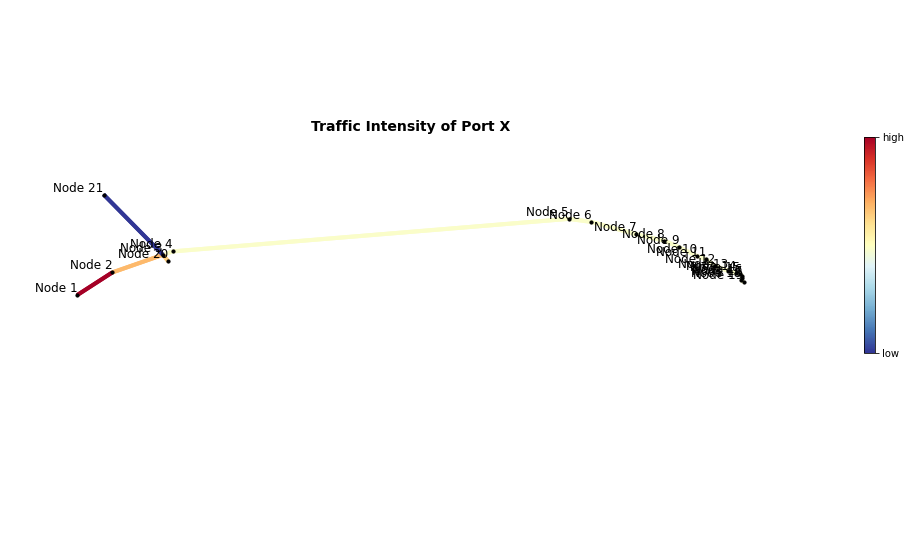

In [31]:
edge_count = np.zeros(len(FG.edges))
for v in vessels:
    df = pd.DataFrame.from_dict(v.log)
    for message in df['Message']:
        if 'Sailing' in message and 'stop' in message:
            r = re.search('Sailing from node (.+?) to node (.+?) stop', message)
            if r:
                node1 = r.group(1)
                node2 = r.group(2)
            for e in enumerate(FG.edges):
                if (node1,node2) == e[1]:
                    edge_count[e[0]] += 1

edge_count_final = np.zeros(len(FG.edges))
for e in enumerate(FG.edges):
    for e2 in enumerate(FG.edges):
        if [e[1][0],e[1][1]] == [e2[1][1],e2[1][0]]:
            edge_count_final[e[0]] = edge_count[e[0]]+edge_count[e2[0]]
            edge_count_final[e2[0]] = edge_count_final[e[0]] 
            break

colormap = cm.get_cmap('RdYlBu_r', 256)
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('off')
ax = fig.add_axes([0, 0.4, 1, 0.3]);
nx.draw(FG, positions, node_size = 10, node_color ='k', with_labels = True, horizontalalignment = 'right', verticalalignment = 'bottom', edge_color = edge_count_final, edge_cmap = colormap, arrows = False, width= 4)
plt.axis('equal')
cbar = fig.colorbar(cm.ScalarMappable(cmap=colormap), ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['low','high'])  # vertically oriented colorbar
plt.title('Traffic Intensity of Port X',fontsize = 14, fontweight='bold')
plt.show()

## Occupancy calculation

In [32]:
def plot_occupancy(infrastructure,duration):
    time_infrastructure_occupation = []
    infrastructure_occupation = []
    infrastructure_capacity = 0
    time_infrastructure_occupation.append(0)
    t = False
    infrastructure_occupation.append(infrastructure_capacity)
    for t in range(len(infrastructure.log["Message"])):
        time_infrastructure_occupation.append(infrastructure.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
        infrastructure_occupation.append(infrastructure_capacity)
        time_infrastructure_occupation.append(infrastructure.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
        infrastructure_occupation.append(infrastructure.log["Value"][t])
        infrastructure_capacity = infrastructure.log["Value"][t]
    
    if t:
        time_infrastructure_occupation.append(duration)
        infrastructure_occupation.append(infrastructure.log["Value"][t])
    return time_infrastructure_occupation,infrastructure_occupation

def occupancy_calculation(infrastructure,duration):
    time_infrastructure_occupation = []
    infrastructure_occupation = []
    infrastructure_capacity = 0
    t = 0
    for t in range(len(infrastructure.log["Message"])):
        if t == 0:
            time_infrastructure_occupation.append(infrastructure.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
            infrastructure_occupation.append(infrastructure_capacity)
        else:
            time_infrastructure_occupation.append(infrastructure.log["Timestamp"][t].timestamp()-infrastructure.log["Timestamp"][t-1].timestamp())
            infrastructure_occupation.append(infrastructure.log["Value"][t-1])
        infrastructure_capacity = infrastructure.log["Value"][t]
    if not t:
        time_infrastructure_occupation.append(0)
        infrastructure_occupation.append(infrastructure_capacity)
        time_infrastructure_occupation.append(duration)
        infrastructure_occupation.append(infrastructure_capacity)
    return time_infrastructure_occupation,infrastructure_occupation

## Terminal occupation output

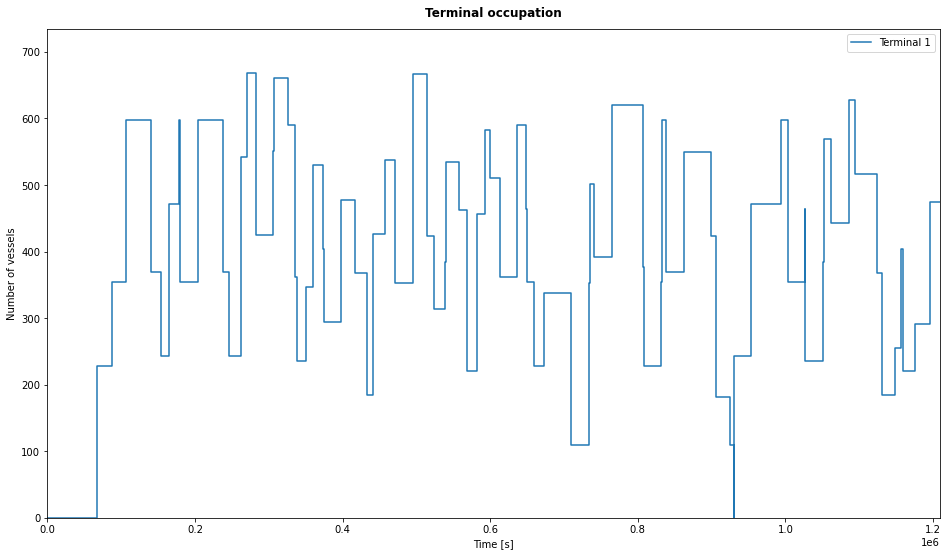

terminal occupancy: 0.5448656767565832


In [33]:
df = pd.DataFrame.from_dict(terminal.log)
df

terminal_edges = [['Node 18','Node 19']]
fig,ax = plt.subplots(figsize=(16, 9))
start = 0
end = duration

for edge in enumerate(terminal_edges):
    terminal = vessels[0].env.FG.edges[edge[1]]['Terminal'][0]
    plt.plot(plot_occupancy(terminal,duration)[0],plot_occupancy(terminal,duration)[1])
    if edge[0] == 0:
        ymax = np.max(occupancy_calculation(terminal,duration)[1])
    elif np.max(occupancy_calculation(terminal,duration)[1]) > ymax:
        ymax = np.max(occupancy_calculation(terminal,duration)[1])

plt.xlabel('Time [s]')
plt.xlim([start,end])
plt.ylabel('Number of vessels')
plt.ylim([0,math.ceil(1.1*ymax)])
plt.title("Terminal occupation", fontweight='bold', pad = 12)
plt.legend(['Terminal 1'])
plt.show()

time_quay_occupation,quay_occupation = occupancy_calculation(terminal,duration)

weighted_quay_occupancy = []
for t in range(len(quay_occupation)):
    weighted_quay_occupancy.append(quay_occupation[t]/max_available_quay_length*time_quay_occupation[t])
      
terminal_occupancy = np.sum(weighted_quay_occupancy)/duration
print('terminal occupancy:',terminal_occupancy)

## Anchorage occupation

In [34]:
# anchorage = vessels[0].env.FG.nodes['Node 20']['Anchorage'][0]
df = pd.DataFrame.from_dict(anchorage.log)
df

,Message,Timestamp,Value,Geometry
0,Vessel arrival,2022-01-26 22:14:09.934776,1,POINT (2.9054 51.92534)
1,Vessel departure,2022-01-26 22:14:09.934776,0,POINT (2.9054 51.92534)
2,Vessel arrival,2022-01-27 20:14:09.934776,1,POINT (2.9054 51.92534)
3,Vessel arrival,2022-01-28 01:44:09.934776,2,POINT (2.9054 51.92534)
4,Vessel departure,2022-01-28 06:29:48.609295,1,POINT (2.9054 51.92534)
...,...,...,...,...
102,Vessel departure,2022-02-08 07:14:09.934776,1,POINT (2.9054 51.92534)
103,Vessel arrival,2022-02-08 12:44:09.934776,2,POINT (2.9054 51.92534)
104,Vessel departure,2022-02-08 14:14:09.934776,1,POINT (2.9054 51.92534)
105,Vessel departure,2022-02-08 15:47:50.908326,0,POINT (2.9054 51.92534)


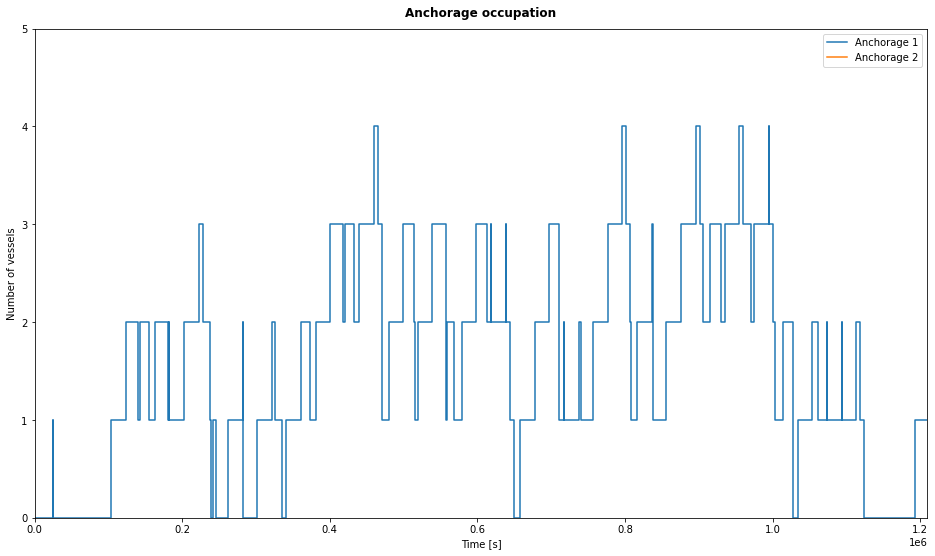

In [35]:
anchorage_nodes = ['Node 20','Node 21']
fig,ax = plt.subplots(figsize=(16, 9))
start = 0
end = duration
for node in enumerate(anchorage_nodes):
    anchorage = vessels[0].env.FG.nodes[node[1]]['Anchorage'][0]
    plt.plot(plot_occupancy(anchorage,duration)[0],plot_occupancy(anchorage,duration)[1])
    if node[0] == 0:
        ymax = np.max(occupancy_calculation(anchorage,duration)[1])
    elif np.max(occupancy_calculation(anchorage,duration)[1]) > ymax:
        ymax = np.max(occupancy_calculation(anchorage,duration)[1])
    
plt.xlabel('Time [s]')
plt.xlim([start,end])
plt.ylabel('Number of vessels')
plt.ylim([0,math.ceil(1.1*ymax)])
plt.title("Anchorage occupation", fontweight='bold', pad = 12)
plt.legend(['Anchorage 1','Anchorage 2'])
plt.show()

In [36]:
anchorage = vessels[0].env.FG.nodes['Node 20']['Anchorage'][0]
time_anchorage_occupation,anchorage_occupation = occupancy_calculation(anchorage,duration)

list_anchorage_occupancy = []
for t in range(len(time_anchorage_occupation)):
    list_anchorage_occupancy.append(anchorage_occupation[t]*(time_anchorage_occupation[t]))

print('Anchorage occupancy:', np.sum(list_anchorage_occupancy)/(duration*anchorage.anchorage_area['Node 20'].capacity))

Anchorage occupancy: 0.03086926482812595


In [37]:
df = pd.DataFrame.from_dict(anchorage.log)
df

,Message,Timestamp,Value,Geometry
0,Vessel arrival,2022-01-26 22:14:09.934776,1,POINT (2.9054 51.92534)
1,Vessel departure,2022-01-26 22:14:09.934776,0,POINT (2.9054 51.92534)
2,Vessel arrival,2022-01-27 20:14:09.934776,1,POINT (2.9054 51.92534)
3,Vessel arrival,2022-01-28 01:44:09.934776,2,POINT (2.9054 51.92534)
4,Vessel departure,2022-01-28 06:29:48.609295,1,POINT (2.9054 51.92534)
...,...,...,...,...
102,Vessel departure,2022-02-08 07:14:09.934776,1,POINT (2.9054 51.92534)
103,Vessel arrival,2022-02-08 12:44:09.934776,2,POINT (2.9054 51.92534)
104,Vessel departure,2022-02-08 14:14:09.934776,1,POINT (2.9054 51.92534)
105,Vessel departure,2022-02-08 15:47:50.908326,0,POINT (2.9054 51.92534)


## Output parameters plots and time-averaged values

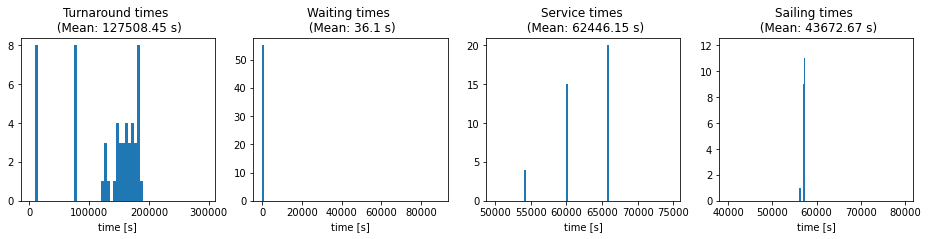

In [38]:
turnaround_times = []
waiting_times = []
sailing_times = []
service_times = []
list_berth_productivity = []
number_of_vessels_served = 0
for v in range(len(vessels)):
    v = v
    start_node = []
    end_node = []
    waiting_time = 0
    sailing_time = 0
    berth_productivity = 1
    was_at_berth = False
    for t in range(len(vessels[v].log["Message"])):
        if t == 0:
            turnaround_start = vessels[v].log["Timestamp"][t].timestamp()
            text = vessels[v].log["Message"][t]
            match = re.search('from node (.+?) to', text)
            if match:
                start_node = match.group(1)
        if 'Waiting in anchorage stop' in vessels[v].log["Message"][t]:
            waiting_time = vessels[v].log['Value'][t]
        if 'Sailing from node' in vessels[v].log["Message"][t] and 'stop' in vessels[v].log["Message"][t]:
            sailing_time += vessels[v].log["Timestamp"][t].timestamp()-vessels[v].log["Timestamp"][t-1].timestamp()
        if 'Loading stop' in vessels[v].log["Message"][t]:
            service_time = vessels[v].log["Timestamp"][t].timestamp()-vessels[v].log["Timestamp"][t-3].timestamp()
            was_at_berth = True
        if 'Deberthing start' in vessels[v].log["Message"][t] and 'Waiting for tidal window stop' in vessels[v].log["Message"][t-1]:
            berth_productivity = service_time/(service_time+vessels[v].log["Value"][t-1])
        if t == len(vessels[v].log["Message"])-1:
            turnaround_end = vessels[v].log["Timestamp"][t].timestamp()
            text = vessels[v].log["Message"][t]
            match = re.search('to node (.+?) stop', text)
            if match:
                end_node = match.group(1)

    if start_node == end_node and end_node != []:
        turnaround_times.append(turnaround_end-turnaround_start)
        waiting_times.append(waiting_time)
        sailing_times.append(sailing_time)
        if was_at_berth == True:
            number_of_vessels_served += 1
            service_times.append(service_time)
        else:
            pass
        list_berth_productivity.append(berth_productivity)

fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16, 3))
ax1.hist(turnaround_times, bins=range(0,300000,5000))
ax1.set_title('Turnaround times \n (Mean: '+ str(round(np.mean(turnaround_times),2)) + ' s)')
ax1.set_xlabel('time [s]')

ax2.hist(waiting_times, bins=range(0,90000,1000))
ax2.set_title('Waiting times \n (Mean: '+ str(round(np.mean(waiting_times),2)) + ' s)')
ax2.set_xlabel('time [s]')

ax3.hist(service_times, bins=range(50000,75000,250))
ax3.set_title('Service times \n (Mean: '+ str(round(np.mean(service_times),2)) + ' s)')
ax3.set_xlabel('time [s]')

ax4.hist(sailing_times, bins=range(40000,80000,100))
ax4.set_title('Sailing times \n (Mean: '+ str(round(np.mean(sailing_times),2)) + ' s)')
ax4.set_xlabel('time [s]')
plt.show()

In [39]:
print('Average berth productivity:',np.mean(list_berth_productivity))

counts, bins = np.histogram(waiting_times, bins=range(0,300000,5000))
counts
# counts, bins = np.histogram(turnaround_times, bins=range(0,300000,5000))
# counts

Average berth productivity: 0.9999043711723725


array([55,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

In [40]:
print('The total number of vessels served is',number_of_vessels_served, 'in a time of', duration, 's.')

The total number of vessels served is 39 in a time of 1209600 s.


In [41]:
np.mean(waiting_times)

36.09880354624358

In [42]:
np.mean(turnaround_times)

127508.44854321913

## Vessel encounters

In [43]:
number_of_encounters = 0
for v1 in range(len(vessels)):
    for v2 in range(len(vessels[(v1+1):])):
        v2 = v2+(v1+1)
        for t1 in range(len(vessels[v1].log["Message"])):
            if 'Sailing from node' in vessels[v1].log["Message"][t1] and 'stop' in vessels[v1].log["Message"][t1]:
                text1 = vessels[v1].log["Message"][t1]
                match1 = re.search('from node (.+?) to', text1)
                match2 = re.search('to node (.+?) stop', text1)
                if match1 and match2:
                    node1 = match1.group(1)
                    node2 = match2.group(1)
                    time_start1 = vessels[v1].log["Timestamp"][t1-1].timestamp()
                    time_stop1 = vessels[v1].log["Timestamp"][t1].timestamp()
                    for t2 in range(len(vessels[v2].log["Message"])):
                        if 'Sailing from node' in vessels[v2].log["Message"][t2] and 'stop' in vessels[v2].log["Message"][t2]:
                            time_start2 = vessels[v2].log["Timestamp"][t2-1].timestamp()
                            time_stop2 = vessels[v2].log["Timestamp"][t2].timestamp()
                            text2 = vessels[v2].log["Message"][t2]
                            if (time_start2 <= time_stop1 and time_start2 >= time_start1) or (time_stop2 <= time_stop1 and time_stop2 >= time_start1):
                                if node2 + ' to' in text2 and node1 + ' stop' in text2:
                                    number_of_encounters += 1          

In [44]:
print('The total number of vessel encounters is',number_of_encounters, 'in a time of', duration, 's.')

The total number of vessel encounters is 94 in a time of 1209600 s.


In [45]:
vessel_list = []
for v in vessels:
    vessel_list.append(v.type)
vessel_list

['Tanker LR2 2',
 'Tanker LR1',
 'Coaster',
 'Tanker LR2 1',
 'Tanker LR1',
 'Coaster',
 'Tanker LR2 1',
 'Handysize',
 'Tanker LR2 2',
 'Small coaster 1',
 'Tanker LR1',
 'Coaster',
 'Coaster',
 'Small coaster 2',
 'Small coaster 2',
 'Tanker MR',
 'Tanker MR',
 'Tanker LR2 1',
 'Small coaster 2',
 'Tanker LR1',
 'Tanker LR2 1',
 'Small coaster 1',
 'Small coaster 1',
 'Handysize',
 'Coaster',
 'Small coaster 2',
 'Coaster',
 'Tanker LR1',
 'Coaster',
 'Small coaster 2',
 'Tanker LR2 2',
 'Tanker LR2 2',
 'Tanker LR2 1',
 'Handysize',
 'Tanker LR1',
 'Tanker LR2 2',
 'Tanker LR2 1',
 'Coaster',
 'Tanker LR2 1',
 'Small coaster 2',
 'Small coaster 1',
 'Tanker LR2 1',
 'Tanker LR2 1',
 'Tanker LR1',
 'Tanker LR2 1',
 'Coaster',
 'Coaster',
 'Small coaster 2',
 'Handysize',
 'Tanker LR2 2',
 'Tanker MR',
 'Tanker MR',
 'Handysize',
 'Tanker LR2 2',
 'Tanker LR2 2',
 'Small coaster 1',
 'Handysize',
 'Small coaster 1',
 'Tanker MR',
 'Tanker LR2 1',
 'Small coaster 2']

In [46]:
from sklearn.decomposition import PCA

In [47]:
def fixed2bearing(east_velocity, north_velocity, principal_direction):
    """
    Function to calculate the velocity components in a reference frame parallel to the principal direction of the
    velocity cluster.
    :param east_velocity: velocity in Eastern direction (float)
    :param north_velocity: velocity in Northern direction (float)
    :param principal_direction: principal direction in degrees in fixed reference frame North-East (float)
    :return: coordinates in a reference frame relative to the given principal direction (tup)
    """
    bearing_rad = np.radians(principal_direction)
    x_velocity = np.cos(bearing_rad) * east_velocity + np.sin(bearing_rad) * north_velocity
    y_velocity = -1 * np.sin(bearing_rad) * east_velocity + np.cos(bearing_rad) * north_velocity
    return x_velocity, y_velocity

def fixed2principal_components(east_velocity_list, north_velocity_list):
    """
    Function to calculate the principal components from a cluster of velocities.
    :param east_velocity_list: list of velocities in Eastern direction (list)
    :param north_velocity_list: list of velocities in Northern direction (list)
    :return: principal direction in degrees (float)
    """
    pca = PCA(n_components=2)  # whiten=True can be added
    X = np.column_stack((east_velocity_list, north_velocity_list))
    X_pca = pca.fit(X)

    y_pca = pca.components_[:, 1][0]  # - pca.mean_[1]
    x_pca = pca.components_[:, 0][0]  # - pca.mean[0]
    theta = np.arctan2(y_pca, x_pca)
    alpha = np.degrees(theta)

    # Correction for positive alpha in coordinate system with positive x-direction upestuary
    if alpha >= 0:
        alpha = alpha - 180  # in degrees
    return alpha

In [48]:
network = FG
node = [14,'Node 15']
lon_vel = []
lat_vel = []
t_vel = network.nodes[node[1]]['Info']['Current direction'][0]
cur_mag = network.nodes[node[1]]['Info']['Current velocity'][1]
cur_dir = network.nodes[node[1]]['Info']['Current direction'][1]
for i in range(len(t_vel)):
    lon_vel.append(cur_mag[i] * np.sin(cur_dir[i] / 180 * np.pi))
    lat_vel.append(cur_mag[i] * np.cos(cur_dir[i] / 180 * np.pi))
prim = fixed2principal_components(lon_vel,lat_vel)
vel = [fixed2bearing(x, y, prim) for x, y in zip(lon_vel,lat_vel)]
vel_prim = [x[0] for x in vel]
interp = sc.interpolate.CubicSpline(t_vel, vel_prim)
roots = interp.roots()
times_tidal_periods = []
prev_root = 0
for root in interp.roots():
    if root > t_vel[0] and root < t_vel[-1] and vel_prim[bisect.bisect_right(t_vel, root)] > 0 and root-prev_root > 0.25*12.5*60*60:
        times_tidal_periods.append([root, 'Flood Start'])
        prev_root = root
    elif root > t_vel[0] and root < t_vel[-1] and vel_prim[bisect.bisect_right(t_vel, root)] < 0 and root-prev_root > 0.25*12.5*60*60:
        times_tidal_periods.append([root, 'Ebb Start'])
        prev_root = root

In [49]:
curvel = pd.read_csv(r'C:\Users\floorbakker\OpenTNSim\notebooks\testdata_OSR\6PE_magnitude.csv',delimiter=',') 
curdir = pd.read_csv(r'C:\Users\floorbakker\OpenTNSim\notebooks\testdata_OSR\6PE_angle.csv',delimiter=',')

In [50]:
node = 'Node 15'
t_vel = network.nodes[node]['Info']['Current direction'][0]
cur_mag = network.nodes[node]['Info']['Current velocity'][1]
cur_dir = [y/180*np.pi for y in network.nodes[node]['Info']['Current direction'][1]]

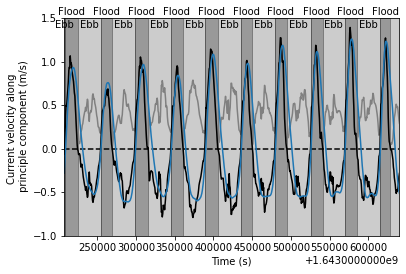

In [51]:
lon_vel = []
lat_vel = []
for i in range(len(t_vel)):
    lon_vel.append(cur_mag[i] * np.sin(cur_dir[i]))
    lat_vel.append(cur_mag[i] * np.cos(cur_dir[i]))
prim = fixed2principal_components(lon_vel,lat_vel)
vel = [fixed2bearing(x, y, prim) for x, y in zip(lon_vel,lat_vel)]
vel_prim = [x[0] for x in vel]
interp = sc.interpolate.CubicSpline(t_vel, vel_prim)
roots = interp.roots()
times_tidal_periods = []
prev_root = 0
for root in interp.roots():
    if root > t_vel[0] and root < t_vel[-1] and vel_prim[bisect.bisect_right(t_vel, root)] > 0 and root-prev_root > 0.25*12.5*60*60:
        times_tidal_periods.append([root, 'Flood Start'])
        prev_root = root
    elif root > t_vel[0] and root < t_vel[-1] and vel_prim[bisect.bisect_right(t_vel, root)] < 0 and root-prev_root > 0.25*12.5*60*60:
        times_tidal_periods.append([root, 'Ebb Start'])
        prev_root = root

plt.plot(t_vel,cur_mag,'grey')
plt.plot(t_vel,interp(t_vel),'k')
plt.axhline(0,color='k',linestyle='--')
previous_time = t_vel[0]
duration = 5*24*60*60
xlimmin = t_vel[0]
xlimmax = xlimmin+duration
ylimmin = -1#1.25*np.min(vel_prim)
ylimmax = 1.5#1.25*np.max(vel_prim)
for times in times_tidal_periods:  
    if times[1] == 'Flood Start':
        plt.fill([previous_time,previous_time,times[0],times[0]],[ylimmin,ylimmax,ylimmax,ylimmin],color='grey',alpha=0.4)
        if times[0] >= xlimmin and times[0] <= xlimmax:
            plt.text(np.mean([previous_time,times[0]]),ylimmax*.925,'Ebb',horizontalalignment  = 'center')
    if times[1] == 'Ebb Start':
        plt.fill([previous_time,previous_time,times[0],times[0]],[ylimmin,ylimmax,ylimmax,ylimmin],color='k',alpha=0.4)
        if times[0] >= xlimmin and times[0] <= xlimmax:
            plt.text(np.mean([previous_time,times[0]]),ylimmax*1.025,'Flood',horizontalalignment  = 'center')
    previous_time = times[0]
plt.xlim([xlimmin,xlimmax])
plt.xlabel('Time (s)')
plt.ylim([ylimmin,ylimmax])
plt.ylabel('Current velocity along \n principle component (m/s)');
plt.plot(network.nodes[node]['Info']['Water level'][0],
         network.nodes[node]['Info']['Water level'][1]);

In [52]:
def fixed2bearing(east_velocity, north_velocity, principal_direction):
    """
    Function to calculate the velocity components in a reference frame parallel to the principal direction of the
    velocity cluster.
    :param east_velocity: velocity in Eastern direction (float)
    :param north_velocity: velocity in Northern direction (float)
    :param principal_direction: principal direction in degrees in fixed reference frame North-East (float)
    :return: coordinates in a reference frame relative to the given principal direction (tup)
    """
    bearing_rad = np.radians(principal_direction)
    x_velocity = np.cos(bearing_rad) * east_velocity + np.sin(bearing_rad) * north_velocity
    y_velocity = -1 * np.sin(bearing_rad) * east_velocity + np.cos(bearing_rad) * north_velocity
    return x_velocity, y_velocity

def fixed2principal_components(east_velocity_list, north_velocity_list):
    """
    Function to calculate the principal components from a cluster of velocities.
    :param east_velocity_list: list of velocities in Eastern direction (list)
    :param north_velocity_list: list of velocities in Northern direction (list)
    :return: principal direction in degrees (float)
    """
    pca = PCA(n_components=2)  # whiten=True can be added
    X = np.column_stack((east_velocity_list, north_velocity_list))
    X_pca = pca.fit(X)

    y_pca = pca.components_[:, 1][0]  # - pca.mean_[1]
    x_pca = pca.components_[:, 0][0]  # - pca.mean[0]
    theta = np.arctan2(y_pca, x_pca)
    alpha = np.degrees(theta)
    return alpha

In [53]:
from scipy import signal
import time
def test_function_pca(t_vel,vel_mag,wlev,vel_dir,tidal_period):
    lon_vel = []
    lat_vel = []
    for i in range(len(t_vel)):
        lon_vel.append(vel_mag[i] * np.sin(vel_dir[i]))
        lat_vel.append(vel_mag[i] * np.cos(vel_dir[i]))
    prim = fixed2principal_components(lon_vel,lat_vel)    
    vel = [fixed2bearing(x, y, prim) for x, y in zip(lon_vel,lat_vel)]
    vel_prim = [x[0] for x in vel]

    def lag_finder(t_vel, wlev, vel_prim,tidal_period):
        nsamples = len(vel_prim)
        b, a = signal.butter(2, 0.1)
        vel_prim = signal.filtfilt(b, a, vel_prim)
        # regularize datasets by subtracting mean and dividing by s.d.
        vel_prim -= np.mean(vel_prim); vel_prim /= np.std(vel_prim)
        wlev -= np.mean(wlev); wlev /= np.std(wlev)
        # Find cross-correlation
        xcorr = correlate(vel_prim, wlev)

        # delta time array to match xcorr
        dt = np.arange(1-nsamples, nsamples)
        time_step = t_vel[1]-t_vel[0]
        delay = 2*(dt[xcorr.argmax()]*time_step/tidal_period)
        print(delay)
        plt.subplots()
        duration = 2.5*24*60*60
        xlimmin = t_vel[0]+5*24*60*60
        xlimmax = xlimmin+duration
        plt.plot(t_vel,wlev)
        plt.plot(t_vel,vel_prim)
        plt.xlim([xlimmin,xlimmax])
        plt.show()
        return delay    
    
    delay = lag_finder(t_vel, wlev, vel_prim,tidal_period)
    
#     if delay < -0.5 or delay > 0:
#         vel_prim = [-1*v for v in vel_prim]

    return t_vel,wlev,vel_prim

-0.5040967616074913


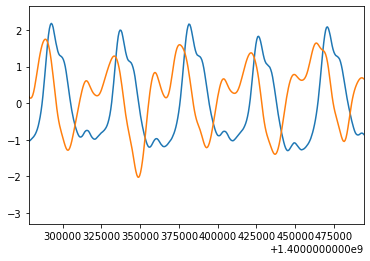

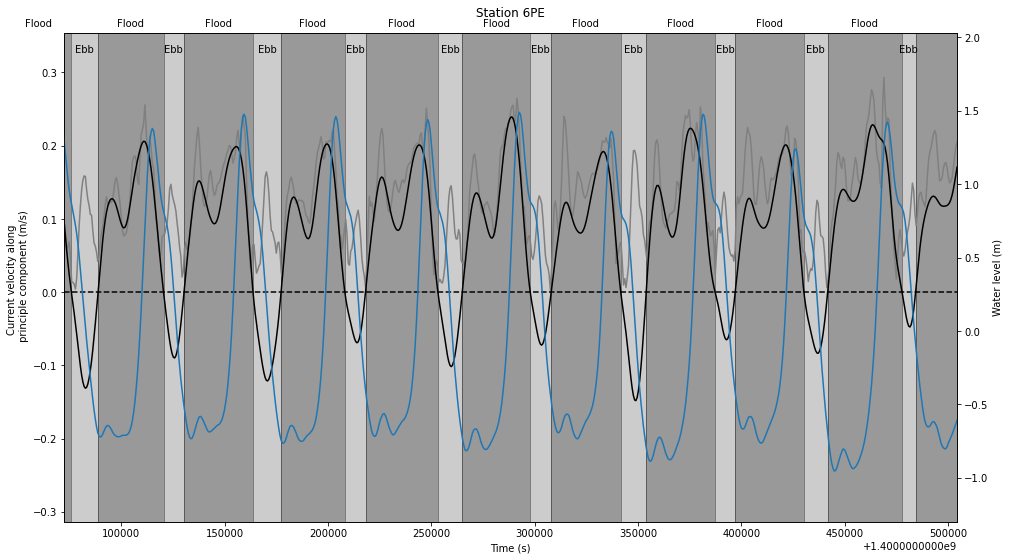

-0.4245025360905189


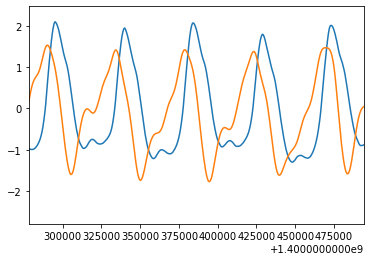

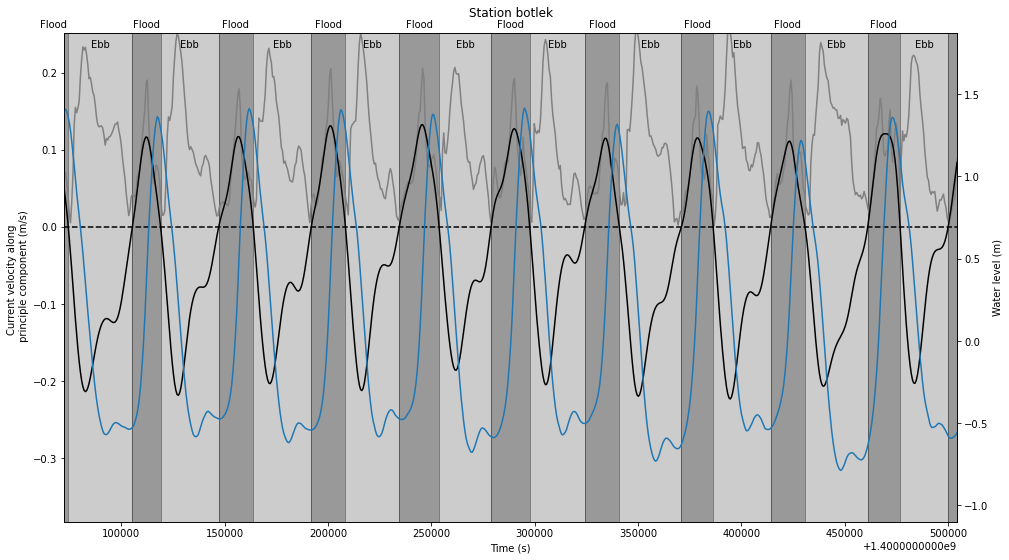

0.0795942255169723


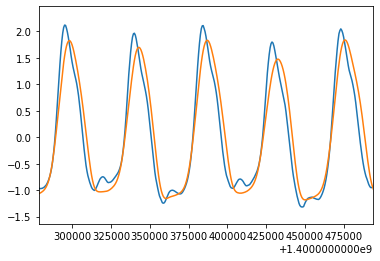

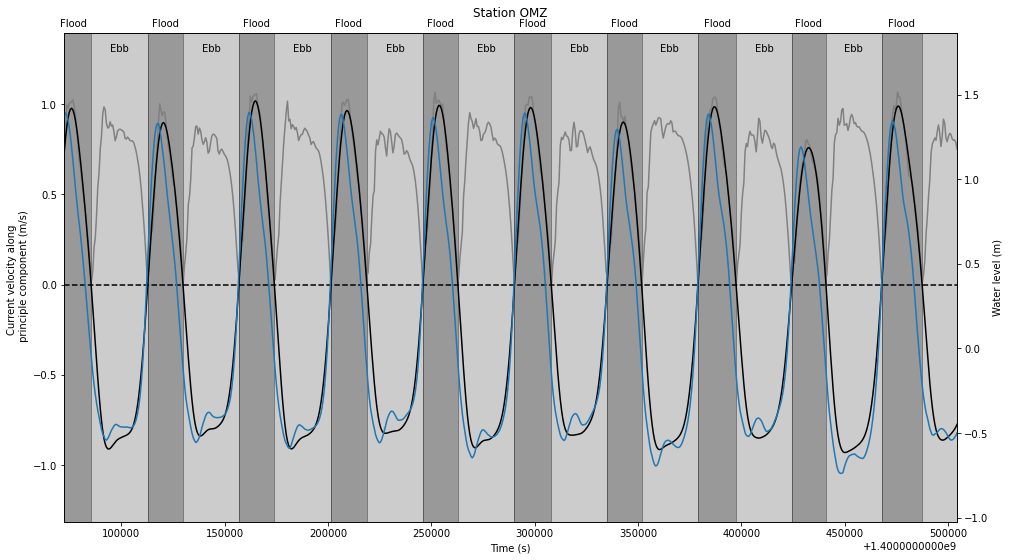

-0.39797112758486153


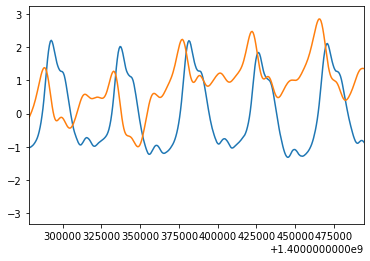

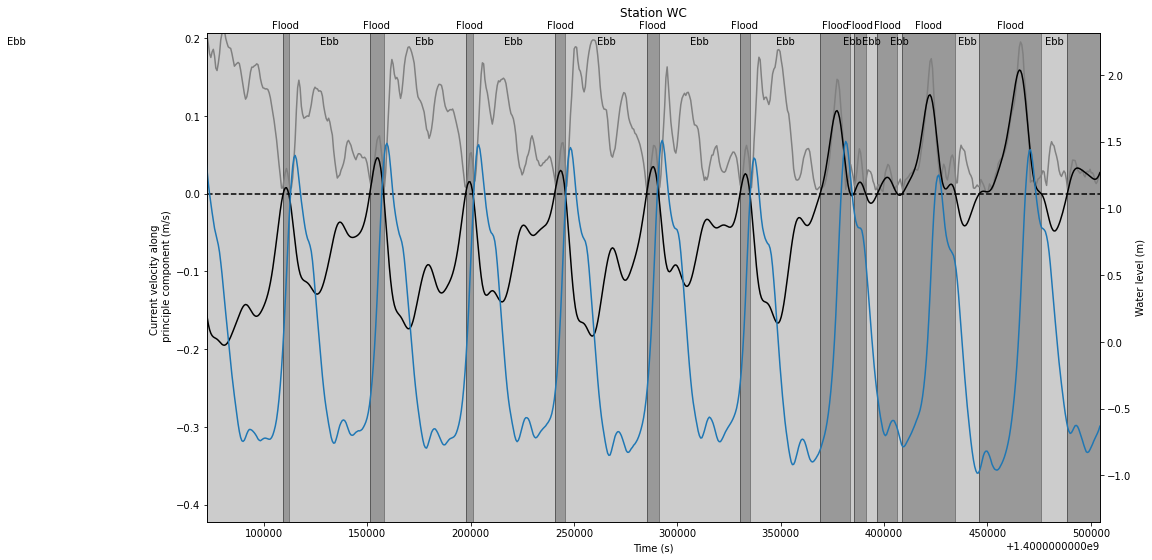

1.5388216933281311


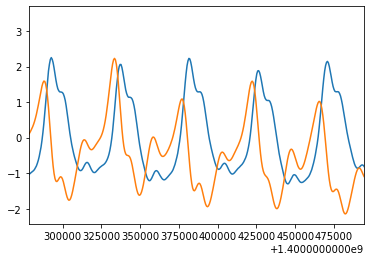

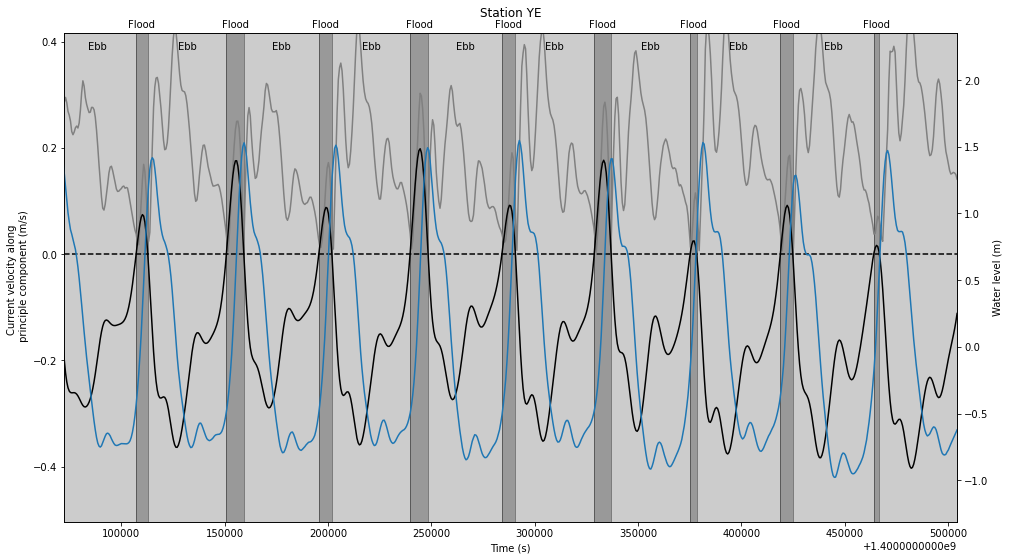

In [54]:
names = ['6PE','botlek','OMZ','WC','YE']
expected_tidal_period = 12.5*60*60

for name in names:
    file_name = os.path.join(os.getcwd(),'testdata_OSR',name+'_magnitude.csv')
    file_name2 = file_name.replace('_magnitude','_water_level')
    file_name3 = file_name.replace('_magnitude','_angle')

    wlev = pd.read_csv(file_name2,delimiter=',') 
    cur_mag = pd.read_csv(file_name,delimiter=',') 
    cur_dir = pd.read_csv(file_name3,delimiter=',') 
    t_vel = [time.mktime(datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").timetuple()) for x in cur_mag['date and time']]        
    cur_mag = cur_mag[cur_mag.columns[1]]
    cur_dir = cur_dir[cur_dir.columns[1]]
    wlev = wlev[wlev.columns[1]]
    
    i_start = bisect.bisect_right(t_vel,5*expected_tidal_period+t_vel[0])
    x = list(t_vel)[i_start:]
    y = list(wlev)[i_start:]
    N = len(x)
    T = x[1]-x[0]
    yf = sc.fft.rfft(y)
    xf = np.fft.fftfreq(N, T)[:N//2]
    tidal_period = 1/xf[np.argmax(yf[1:])]/60/60
    i_start = bisect.bisect_right(t_vel,5*tidal_period+t_vel[0])
    t_vel = list(t_vel)[i_start:]        
    cur_mag = list(cur_mag)[i_start:]  
    cur_dir = list(cur_dir)[i_start:]  
    wlev = list(wlev)[i_start:]  
    
    [t_vel,wlev,vel_prim] = test_function_pca(t_vel,cur_mag,wlev,cur_dir,tidal_period*60*60)
    b, a = signal.butter(2, 0.1)
    vel_prim = signal.filtfilt(b, a, vel_prim)

    interp = sc.interpolate.CubicSpline(t_vel, vel_prim)
    roots = interp.roots()
    times_tidal_periods = []
    time_step = t_vel[1]-t_vel[0]
    roots = list(interp.roots())
    for root in roots:
        if root > t_vel[0] and root < t_vel[-1] and vel_prim[bisect.bisect_right(t_vel, root)] > 0:
            if (times_tidal_periods == [] or (times_tidal_periods != [] and times_tidal_periods[-1][1] != 'Flood Start')):
                times_tidal_periods.append([root, 'Flood Start'])
        elif root > t_vel[0] and root < t_vel[-1] and vel_prim[bisect.bisect_right(t_vel, root)] < 0: 
            if (times_tidal_periods == [] or (times_tidal_periods != [] and times_tidal_periods[-1][1] != 'Ebb Start')):
                times_tidal_periods.append([root, 'Ebb Start'])

    fig, ax1 = plt.subplots(figsize=[16,9])
    ax1.plot(t_vel,cur_mag,'grey')
    ax1.plot(t_vel,interp(t_vel),'k')
    ax1.axhline(0,color='k',linestyle='--')
    previous_time = t_vel[0]
    duration = 5*24*60*60
    xlimmin = t_vel[0]+5*tidal_period*60*60
    xlimmax = xlimmin+duration
    ylimmin = 1.25*np.min(vel_prim)
    ylimmax = 1.25*np.max(vel_prim)
    for times in times_tidal_periods:  
        if times[1] == 'Flood Start':
            ax1.fill([previous_time,previous_time,times[0],times[0]],[ylimmin,ylimmax,ylimmax,ylimmin],color='grey',alpha=0.4)
            if times[0] >= xlimmin and times[0] <= xlimmax:
                ax1.text(np.mean([previous_time,times[0]]),ylimmax*.925,'Ebb',horizontalalignment  = 'center')
        if times[1] == 'Ebb Start':
            ax1.fill([previous_time,previous_time,times[0],times[0]],[ylimmin,ylimmax,ylimmax,ylimmin],color='k',alpha=0.4)
            if times[0] >= xlimmin and times[0] <= xlimmax:
                ax1.text(np.mean([previous_time,times[0]]),ylimmax*1.025,'Flood',horizontalalignment  = 'center')
        previous_time = times[0]
    ax1.set_xlim([xlimmin,xlimmax])
    ax1.set_xlabel('Time (s)')
    ax1.set_ylim([ylimmin,ylimmax])
    ax1.set_ylabel('Current velocity along \n principle component (m/s)');

    ax2 = ax1.twinx() 
    duration = 5*24*60*60
    xlimmin = t_vel[0]+5*tidal_period*60*60
    xlimmax = xlimmin+duration
    ylimmin = 1.25*np.min(wlev)
    ylimmax = 1.25*np.max(wlev)
    ax2.plot(t_vel,wlev)
    ax2.plot()
    ax2.set_xlim([xlimmin,xlimmax])
    ax2.set_xlabel('Time (s)')
    ax2.set_ylim([ylimmin,ylimmax])
    ax2.set_ylabel('Water level (m)')
    plt.title('Station '+name,pad=16)
    plt.show();

In [55]:
class Environment:
    def __init__(self,start_time,network):
        self.now = start_time
        self.FG = network

class Vessel:
    def __init__(self,start_time,T,ukc,typ,v,L,B,mccur,mwt,bound,network,start_node,end_node):
        self.env = Environment(start_time,network)
        self.T_f = T
        self.L = L
        self.v = v
        self.B = B
        self.ukc = ukc
        self.metadata = {}
        self.metadata['ukc'] = ukc
        self.metadata['max_cross_current'] = mccur
        self.metadata['max_waiting_time'] = mwt
        self.bound = bound
        self.type = typ
        self.route = nx.dijkstra_path(self.env.FG, start_node, end_node)

In [ ]:
def test_tidal_window_visualization(start_node,end_node,T_lower_limit,T_upper_limit,T_ticks):
    T_list = np.arange(T_lower_limit,T_upper_limit,T_ticks)
    route = nx.dijkstra_path(FG, start_node, end_node)
    vesseltjes = []
    vesseltje = []
    print(start_node,end_node)
    for i in range(len(T_list)):
        vesseltje.append(Vessel(start_time = simulation_start.timestamp(),
                                T = T_list[i],
                                L = 149,
                                v = 4.5,
                                B = 27,
                                ukc = 0,
                                mccur = 0,
                                mwt = 64*60*60,
                                bound = 'in',
                                typ = 'Handysize',
                                network = network,
                                start_node = start_node,
                                end_node = end_node))
    vesseltjes.append(vesseltje)
    tws = []
    for vesseltje in range(len(vesseltjes)):
        tw = []
        for v in range(len(vesseltjes[vesseltje])):
            tw.append(core.NetworkProperties.calculate_available_sail_in_times(vesseltjes[vesseltje][v],
                                                                                vertical_tidal_window = True,
                                                                                horizontal_tidal_window  = True,
                                                                                route = vesseltjes[vesseltje][v].route,
                                                                                out=False,
                                                                                plot=False,
                                                                                sailing_time_correction = False))
        tws.append(tw)

    twtjes = []
    end =  10*12.5*60*60
    s = simulation_start.timestamp()
    for vesseltje in range(len(vesseltjes)):
        twtje = []
        for v in range(len(vesseltjes[vesseltje])):
            if tws[vesseltje][v] != []:
                if tws[vesseltje][v][0][1] == 'Stop':
                    twtje.append([[tws[vesseltje][v][t[0]-1][0]-s,t[1][0]-s] for t in enumerate(tws[vesseltje][v]) if t[1][1] == 'Start'])
                else:
                    twtje.append([[t[1][0]-s,tws[vesseltje][v][t[0]+1][0]-s] for t in enumerate(tws[vesseltje][v]) if t[1][1] == 'Stop' and t[0] != len(tws[vesseltje][v])-1])
            else:
                twtje.append([[simulation_start.timestamp()-s,simulation_start.timestamp()+end-s],
                              [simulation_start.timestamp()-s,simulation_start.timestamp()+end-s]])
        twtjes.append(twtje)

    indexes = []
    locaties = []
    tijdjess = []
    waardens = []
    for twtje in enumerate(twtjes):
        tijd = []
        end_t = 10*12.5*60*60
        for tw in twtje[1]:
            for t in tw:
                if t[1] <= end:
                    tijd.extend([t[0],t[1]])
                elif t[0] <= end:
                    tijd.extend([t[0],end])
                else:
                    break
        tijd.sort()
        tijdjes = list(dict.fromkeys(tijd))
        tijdjes.append(end)
        waarden = np.zeros(len(tijdjes))
        for tw in enumerate(twtje[1]):
            for t in enumerate(tw[1]):
                if t[0] == 0 and t[1][0] <= end and t[1][1] >= end:
                    t[1][0] = 0
                    t[1][1] = end
                if t[1][1] <= end:                 
                    indx1 = tijdjes.index(t[1][0])
                    indx2 = tijdjes.index(t[1][1])
                    for i in enumerate(tijdjes[indx1:indx2+1]):
                        waarden[i[0]+indx1] = vesseltjes[twtje[0]][tw[0]].T_f
            
            if twtje[0] == 14:
                plt.subplots()
                plt.plot(tijdjes,waarden)
                plt.plot(tijdjes,waarden,'ko')
                plt.plot([x-s for x in FG.nodes['Node 15']['Info']['Water level'][0]],
                         [(y+FG.nodes['Node 15']['Info']['Depth'][0])/1.125 for y in FG.nodes['Node 15']['Info']['Water level'][1]])
                plt.xlim([0,90000])
                plt.show()
                
        tijdjess.extend(tijdjes)
        waardens.extend(waarden)
        vesseltje = vesseltjes[twtje[0]][0]         
        route = nx.dijkstra_path(FG,'Node 1',vesseltjes[twtje[0]][0].route[-1])
        previous_node = 'Node 1'
        distance = 0
        for node in route:
            if node != previous_node:        
                distance += calculate_distance([FG.nodes[previous_node]['geometry'].x,FG.nodes[previous_node]['geometry'].y],
                                               [FG.nodes[node]['geometry'].x,FG.nodes[node]['geometry'].y])
                previous_node = node

        locaties.extend(list(distance*np.ones(len(tijdjes))))
        if twtje[0] != len(twtjes)-1:
            indexes.append(len(locaties)-1)

    return indexes,locaties,tijdjess,waardens

In [ ]:
def test_tidal_window_visualization2(start_node,end_node,T_lower_limit,T_upper_limit,T_ticks,bound):
    T_list = np.arange(T_lower_limit,T_upper_limit,T_ticks)
    route = nx.dijkstra_path(FG, start_node, end_node)
    vesseltjes = []
    vesseltje = []
    print(start_node,end_node)
    for i in range(len(T_list)):
        vesseltje.append(Vessel(start_time = simulation_start.timestamp(),
                                T = T_list[i],
                                L = 149,
                                v = 4.5,
                                B = 27,
                                ukc = 0,
                                mccur = 0,
                                mwt = 64*60*60,
                                bound = bound,
                                typ = 'Handysize',
                                network = network,
                                start_node = start_node,
                                end_node = end_node))
    vesseltjes.append(vesseltje)
    tws = []
    for vesseltje in range(len(vesseltjes)):
        tw = []
        for v in range(len(vesseltjes[vesseltje])):
            tw.append(core.NetworkProperties.calculate_available_sail_in_times(vesseltjes[vesseltje][v],
                                                                                vertical_tidal_window = True,
                                                                                horizontal_tidal_window  = True,
                                                                                route = vesseltjes[vesseltje][v].route,
                                                                                out=False,
                                                                                plot=True,
                                                                                sailing_time_correction = False,
                                                                                visualization_calculation=True))
        tws.append(tw)

    twtjes = []
    end =  10*12.5*60*60
    s = simulation_start.timestamp()
    for vesseltje in range(len(vesseltjes)):
        twtje = []
        for v in range(len(vesseltjes[vesseltje])):
            if tws[vesseltje][v] != []:
                if tws[vesseltje][v][0][1] == 'Stop':
                    twtje.append([[tws[vesseltje][v][t[0]-1][0]-s,t[1][0]-s] for t in enumerate(tws[vesseltje][v]) if t[1][1] == 'Start'])
                else:
                    twtje.append([[t[1][0]-s,tws[vesseltje][v][t[0]+1][0]-s] for t in enumerate(tws[vesseltje][v]) if t[1][1] == 'Stop' and t[0] != len(tws[vesseltje][v])-1])
            else:
                twtje.append([[simulation_start.timestamp()-s,simulation_start.timestamp()+end-s],
                              [simulation_start.timestamp()-s,simulation_start.timestamp()+end-s]])
        twtjes.append(twtje)

    indexes = []
    locaties = []
    tijdjess = []
    waardens = []
    for twtje in enumerate(twtjes):
        tijd = []
        end_t = 10*12.5*60*60
        for tw in twtje[1]:
            for t in tw:
                tijd.extend([t[0],t[1]])
        tijd.sort()
        tijden = list(dict.fromkeys(tijd))
        tijdjes = []
        tijdjes.append(0)
        tijdjes.append(end)
        for t in enumerate(tijden):
            if t[0] != 0 and t[0] != len(tijden)-1:
                tijdjes.extend([t[1],t[1]])
            else:
                tijdjes.append(t[1])
        tijdjes.append(end)
        waarden = np.zeros(len(tijdjes))       
        for tw in enumerate(twtje[1]):
            for t in enumerate(tw[1]):
                if t[0] == 0 and t[1][0] <= end and t[1][1] >= end:
                    t[1][0] = 0
                    t[1][1] = end
                if t[1][1] <= end:
                    indx1 = tijdjes.index(t[1][0])
                    indx2 = tijdjes.index(t[1][1])
                    if indx2 != len(tijdjes)-1 and t[1][1] != end:
                        if indx1 != 0:
                            indx1 = indx1+1
                        for i in enumerate(tijdjes[indx1:indx2+1]):
                            waarden[i[0]+indx1] = vesseltjes[twtje[0]][tw[0]].T_f
                    else:
                        if indx1 != 0:
                            indx1 = indx1+1
                            for i in enumerate(tijdjes[indx1:]):
                                waarden[i[0]+indx1] = vesseltjes[twtje[0]][tw[0]].T_f
                        else:
                            for i in enumerate(tijdjes):
                                waarden[i[0]] = vesseltjes[twtje[0]][tw[0]].T_f
                            break
                elif t[1][0] <= end:
                    indx1 = tijdjes.index(t[1][0])+1
                    for i in enumerate(tijdjes[indx1:]):
                        waarden[i[0]+indx1] = vesseltjes[twtje[0]][tw[0]].T_f
                    
        tijdjess.extend(tijdjes)
        waardens.extend(waarden)
        
        vesseltje = vesseltjes[twtje[0]][0]
        route = nx.dijkstra_path(FG,'Node 1',vesseltjes[twtje[0]][0].route[-1])
        previous_node = 'Node 1'
        distance = 0
        for node in route:
            if node != previous_node:        
                distance += calculate_distance([FG.nodes[previous_node]['geometry'].x,FG.nodes[previous_node]['geometry'].y],
                                               [FG.nodes[node]['geometry'].x,FG.nodes[node]['geometry'].y])
                previous_node = node

        locaties.extend(list(distance*np.ones(len(tijdjes))))
        if twtje[0] != len(twtjes)-1:
            indexes.append(len(locaties)-1)

    return indexes,locaties,tijdjess,waardens

In [ ]:
I = []
X = []
Y = []
Z = []
route = nx.dijkstra_path(FG, 'Node 1', 'Node 19')
T_lower_limit = 4.5
T_ticks = 0.05
T_upper_limit = 16+T_ticks
for node in enumerate(route):
    i,x,y,z = test_tidal_window_visualization(node[1],node[1],T_lower_limit,T_upper_limit,T_ticks)
    I.append(i)
    X.append(x)
    Y.append(y)
    Z.append(z)

In [ ]:
x_int = []
y_int = []
z_int = []
for x in enumerate(X):  
    intrp = sc.interpolate.interp1d(Y[x[0]],Z[x[0]])
    y_intrp = np.linspace(start,end,1000)
    x_intrp = x[1][0]*np.ones(1000)
    z_intrp = intrp(y_intrp)
    x_int.append(x_intrp)
    y_int.append(y_intrp)
    z_int.append(z_intrp)

In [ ]:
I = []
X = []
Y = []
Z = []
route = nx.dijkstra_path(FG, 'Node 15', 'Node 15')
T_lower_limit = 4.5
T_ticks = 0.05
T_upper_limit = 16+T_ticks
for node in enumerate(route):
    i,x,y,z = test_tidal_window_visualization2(node[1],node[1],T_lower_limit,T_upper_limit,T_ticks,'inbound')
    I.append(i)
    X.append(x)
    Y.append(y)
    Z.append(z)

In [ ]:
x_int2 = []
y_int2 = []
z_int2 = []
for x in enumerate(X):  
    intrp = sc.interpolate.interp1d(Y[x[0]],Z[x[0]])
    y_intrp = np.linspace(start,end,1000)
    x_intrp = x[1][0]*np.ones(1000)
    z_intrp = intrp(y_intrp)
    x_int2.append(x_intrp)
    y_int2.append(y_intrp)
    z_int2.append(z_intrp)

In [ ]:
I = []
X = []
Y = []
Z = []
route = nx.dijkstra_path(FG, 'Node 15', 'Node 15')
T_lower_limit = 4.5
T_ticks = 0.05
T_upper_limit = 16+T_ticks
for node in enumerate(route):
    i,x,y,z = test_tidal_window_visualization2(node[1],node[1],T_lower_limit,T_upper_limit,T_ticks,'outbound')
    I.append(i)
    X.append(x)
    Y.append(y)
    Z.append(z)

In [ ]:
x_int3 = []
y_int3 = []
z_int3 = []
for x in enumerate(X):  
    intrp = sc.interpolate.interp1d(Y[x[0]],Z[x[0]])
    y_intrp = np.linspace(start,end,1000)
    x_intrp = x[1][0]*np.ones(1000)
    z_intrp = intrp(y_intrp)
    x_int3.append(x_intrp)
    y_int3.append(y_intrp)
    z_int3.append(z_intrp)

In [ ]:
terminal = vessels[0].env.FG.edges['Node 18','Node 19']['Terminal'][0]
if terminal.type == 'quay':
    max_available_quay_length = terminal.length.capacity
if terminal.type == 'jetty':
    max_available_quay_length = 5
    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

def calculate_alpha(cf, cb):
    a = cb[-1] + cf[-1] - cb[-1] * cf[-1]
    return a

def calc_distance(node1,node2):
    route = nx.dijkstra_path(FG,node1,node2)
    distance = 0
    previous_node = node1
    for node in route:
        distance += calculate_distance([FG.nodes[previous_node]['geometry'].x,FG.nodes[previous_node]['geometry'].y],
                                       [FG.nodes[node]['geometry'].x,FG.nodes[node]['geometry'].y])
        previous_node = node
    return distance

#alphas = np.linspace(0,1,50)
#colors = [make_rgb_transparent(mpl.colors.to_rgb('lightgreen'),[1,1,1],a) for a in alphas]
#cmap = mpl.colors.ListedColormap(colors)
colors = []
colors.append([1,1,1])
for c in enumerate(mpl.colorbar.cm.tab20.colors):
    if (c[0]-1)%2 == 0 and c[0] <= 16:
        colors.append(c[1])
bounds = list(vdf['T_f'])
bounds.insert(0,0)
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(boundaries=bounds,ncolors=9, extend='max')
cmap_plot = mpl.colors.ListedColormap(colors[1:])
norm_plot = mpl.colors.BoundaryNorm(boundaries=bounds[1:],ncolors=8, extend='max')

vesseltje = vessels[0]
start = 0
end =  10*12.5*60*60
end_cor = 0#5*12.5*60*60
ax3xlist = [eta+depth[1][16] for eta in water_level[1][16][1]] #let's define it at node 15 to visualize when we have the critical bed level of MBL=-16.4m NAP
ax3ylist = [t-simulation_start.timestamp() for t in water_level[1][16][0]] 
ax4xlist = current_velocity[1][13][1]
ax4ylist = [t-simulation_start.timestamp() for t in current_velocity[1][14][0]]
required_water_level = vesseltje.metadata['ukc'] + vesseltje.T_f
    
if terminal.type == 'quay':
    time_available_quay_length = []
    available_quay_length = []
    quay_level = 0
    time_available_quay_length.append(0)
    available_quay_length.append(quay_level)
    for t in range(len(terminal.log["Message"])):
        time_available_quay_length.append(terminal.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
        available_quay_length.append(quay_level)
        time_available_quay_length.append(terminal.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
        available_quay_length.append(terminal.log["Value"][t])
        quay_level = terminal.log["Value"][t]
        
if terminal.type == 'jetty':
    time_available_quay_length = []
    available_quay_length = []
    quay_level = 0
    time_available_quay_length.append(0)
    available_quay_length.append(quay_level)
    for t in range(len(terminal.log["Message"])):
        time_available_quay_length.append(terminal.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
        available_quay_length.append(quay_level)
        time_available_quay_length.append(terminal.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
        available_quay_length.append(terminal.log["Value"][t])
        quay_level = terminal.log["Value"][t]
    
anchorage = vessels[0].env.FG.nodes['Node 20']['Anchorage'][0]
time_anchorage_occupation = []
anchorage_occupation = []
anchorage_capacity = 0
time_anchorage_occupation.append(0)
anchorage_occupation.append(anchorage_capacity)
for t in range(len(anchorage.log["Message"])):
    time_anchorage_occupation.append(anchorage.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
    anchorage_occupation.append(anchorage_capacity)
    time_anchorage_occupation.append(anchorage.log["Timestamp"][t].timestamp()-simulation_start.timestamp())
    anchorage_occupation.append(anchorage.log["Value"][t])
    anchorage_capacity = anchorage.log["Value"][t]

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(16, 9),gridspec_kw={'width_ratios': [3.5, 0.25, 0.25, 1, 1, 1]})
ax1.patch.set_alpha(0)
ax2.patch.set_alpha(0)
ax3.patch.set_alpha(0)
ax4.patch.set_alpha(0)
ax1.set_xlim([0,125000])
figxlimits = ax1.axes.get_xlim()
for y in enumerate(y_int[0]):
    x_intrp_old = [x[y[0]] for x in x_int]
    z_intrp_old = [z[y[0]] for z in z_int]
    intrp = sc.interpolate.interp1d(x_intrp_old,z_intrp_old,fill_value='extrapolate')
    x_intrp = np.linspace(0,figxlimits[1],1000)
    y_intrp = y[1]*np.ones(1000)
    z_intrp = intrp(x_intrp)
    ax1.scatter(x_intrp,y_intrp,s=2,c=z_intrp,norm=norm,cmap=cmap)
    
for y in enumerate(y_int2[0]):
    x_intrp_old2 = [[x for x in x_int2][0][y[0]]-100,[x for x in x_int2][0][y[0]]+100]
    z_intrp_old2 = [[z for z in z_int2][0][y[0]],[z for z in z_int2][0][y[0]]]
    intrp = sc.interpolate.interp1d(x_intrp_old2,z_intrp_old2,fill_value='extrapolate')
    x_intrp = np.linspace(-100+horizontal_tidal_restriction_distance,100+horizontal_tidal_restriction_distance,1000)
    y_intrp = y[1]*np.ones(1000)
    z_intrp = intrp(x_intrp)
    ax2.scatter(x_intrp,y_intrp,s=2,c=z_intrp,norm=norm,cmap=cmap)
    
for y in enumerate(y_int3[0]):
    x_intrp_old2 = [[x for x in x_int3][0][y[0]]-100,[x for x in x_int3][0][y[0]]+100]
    z_intrp_old2 = [[z for z in z_int3][0][y[0]],[z for z in z_int3][0][y[0]]]
    intrp = sc.interpolate.interp1d(x_intrp_old2,z_intrp_old2,fill_value='extrapolate')
    x_intrp = np.linspace(-100+horizontal_tidal_restriction_distance,100+horizontal_tidal_restriction_distance,1000)
    y_intrp = y[1]*np.ones(1000)
    z_intrp = intrp(x_intrp)
    ax3.scatter(x_intrp,y_intrp,s=2,c=z_intrp,norm=norm,cmap=cmap)
    
vessel_types = list(vdf['type'])
vessel_drafts = list(vdf['T_f'])
vessel_ukcs = list(vdf['ukc'])
horizontal_tidal_restriction_distance = calc_distance('Node 1','Node 15')
ax1.axvline(distance_to_anchorage,color = 'k',linestyle = '--')
ax1.fill([horizontal_tidal_restriction_distance-1000,
          horizontal_tidal_restriction_distance,
          horizontal_tidal_restriction_distance,
          horizontal_tidal_restriction_distance-1000],
         [start,start,end,end],fill=False,color='k')
ax1.axvline(122000,color = 'k',linestyle = '--')
ax1.text(horizontal_tidal_restriction_distance-1500,0.95*(end-end_cor),'Horizontal\n Tidal Restriction',horizontalalignment  = 'right')
ax1.text(distance_to_anchorage,1.02*(end-end_cor),'Anchorage',horizontalalignment  = 'center')
ax1.text(122000,1.02*(end-end_cor),'Terminal',horizontalalignment  = 'right')
vessel_types = list(vdf['type'])
for v in reversed(range(0,len(vessels)-1)):
    color,linewidth = color_vessels(vessels[v])
    ax1.plot(vessel_path_x[v],vessel_path_t[v],color=color,linewidth=linewidth)
vessel_legend(ax1,vessel_types)
ax1.set_title("Tracking diagram and vertical tidal restriction for\n vessels calling at Koole Terminal (3e Petroleumhaven)", fontweight='bold', pad = 32)
ax1.set_xlabel('Distance [m]')
ax1.set_xlim(figxlimits)
ax1.set_ylabel('Time [s]')
ax1.set_ylim([start,end-end_cor]);

ax2.set_xlim([-100+horizontal_tidal_restriction_distance,100+horizontal_tidal_restriction_distance])
for v in reversed(range(0,len(vessels)-1)):
    color,linewidth = color_vessels(vessels[v])
    ax2.plot(vessel_path_x[v][:int(0.5*len(vessel_path_x[1]))],vessel_path_t[v][:int(0.5*len(vessel_path_x[1]))],color=color,linewidth=linewidth)
ax2.set_ylim([start,end-end_cor])
ax2.set_title("Horizontal\n Tidal\n Restriction", fontweight='bold', position = [1.4,1.4],pad=26)
ax2.text(horizontal_tidal_restriction_distance,1.01*(end-end_cor),'inbound\n vessels',horizontalalignment  = 'center')
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)

ax3.set_xlim([-100+horizontal_tidal_restriction_distance,100+horizontal_tidal_restriction_distance])
for v in reversed(range(0,len(vessels)-1)):
    color,linewidth = color_vessels(vessels[v])
    ax3.plot(vessel_path_x[v][int(0.5*len(vessel_path_x[1])):],vessel_path_t[v][int(0.5*len(vessel_path_x[1])):],color=color,linewidth=linewidth)
ax3.set_ylim([start,end-end_cor])
ax3.text(horizontal_tidal_restriction_distance,1.01*(end-end_cor),'outbound\n vessels',horizontalalignment  = 'center')
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)

ax4.plot([max_available_quay_length-x for x in available_quay_length],time_available_quay_length)
ax4.set_xlim([0,1.1*max_available_quay_length])
figxlimits = ax4.axes.get_xlim()
if terminal.type == 'quay':
    ax4.axvline(vessels[0].L,color = 'k', linestyle = '--')
    ax4.set_title("Available quay length \n over time", fontweight='bold', pad = 32)
    ax4.text(vessels[0].L,1.01*end,'Required quay \n length',horizontalalignment = 'center') 
elif terminal.type == 'jetty':
    ax4.axvline(1,color = 'k', linestyle = '--')
    ax4.set_title("Available jetties \n over time", fontweight='bold', pad = 32)
ax4.set_xlim(figxlimits)
ax4.yaxis.set_visible(False)
ax4.set_ylim([start,end-end_cor])
ax4.set_xlabel('Number of jetties [-]');

ax5.plot(ax3xlist,ax3ylist)
ax5.plot([eta+depth[1][6] for eta in water_level[1][6][1]],ax3ylist,c='#1f77b4')
ax5.set_ylim([start,end-end_cor])
figxlimits = ax5.axes.get_xlim()
ax5.yaxis.set_visible(False)
ax5.set_ylim([start,end-end_cor])
ax5.set_xlim(figxlimits)
ax5.set_xlabel('Water depth [m]');
ax5.set_title("Available water\n depth over\n time", fontweight='bold', pad = 26)
ax5.yaxis.set_visible(False)

ax6.set_xlabel('Current \n velocity [m/s]',horizontalalignment = 'center');
ax6.plot(ax4xlist,ax4ylist)
ax6.set_ylim([start,end-end_cor])
figxlimits = ax6.axes.get_xlim()
ax6.set_title("Current\n velocity\n over time", fontweight='bold', pad = 26)
ax6.set_ylim([start,end-end_cor])
ax6.set_xlim(figxlimits)
ax6.yaxis.set_visible(False)

cax = fig.add_axes([0.925, 0.125, 0.01, 0.755])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap_plot,norm=norm_plot, orientation='vertical')
cbar.set_label('Maximum draught of vessel that is allowed to sail [m]')
plt.show();
extent = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('kunst.png', dpi=300,bbox_inches=extent.expanded(1.0, 1.2));

In [ ]:
import importlib
importlib.reload(core)

vesselt = Vessel(start_time = simulation_start.timestamp(),
                    T = 10,
                    L = 180,
                    v = 4.5,
                    B = 27,
                    ukc = 0,
                    mccur = 0,
                    mwt = 64*60*60,
                    bound = 'outbound',
                    typ = 'Handysize',
                    network = FG,
                    start_node = 'Node 15',
                    end_node = 'Node 15')

_ = core.NetworkProperties.calculate_available_sail_in_times(vesselt,
                                                             vertical_tidal_window = True,
                                                             horizontal_tidal_window  = True,
                                                             route =vesselt.route,
                                                             out=True,
                                                             plot=True,
                                                             sailing_time_correction = True,
                                                             visualization_calculation = True)